# SALES COMMENTARY GENERATION - Exploration

#### Author: Utkarsh Chaturvedi

__Before we begin with the detailed exploration, a list of data discrepancies were discovered by just eye-balling the data. Please refer to the report for their detailed explanation. They are listed below:__
1. There are 2 versions of actual sales for some product groups. They seem to be present in Sales file of current year and the following year. 
2. There are cases where commentaries are present, but corresponding business plans were missing from consumer sales data i.e. there is a commentary for ACT 2018 vs. JU/NU 2018, but the JU/NU is not present in consumer sales data
3. The exact magnitude of missing data in point (2) is difficult to gauge because of the levels at which commentaries have been written, which in-itself raises a question and needs an answer before proceeding; the “product-group” in the commentaries data-set is not uniform across Franchise Level 1 or 2. 
4. A look-back correction seems to be happening for JU & NU updates. The following comparisons will be valid while generating commentary:
    * Month 1-4: FBP
    * Month 5-9: JU 
    * Month 10-12: NU 

## Loading Data and importing resources

In [1]:
# import resources
%matplotlib inline
import pandas as pd
import datetime as dt
import os # for navigating to the required directory
import re # for regex manipulation
import itertools #for iterating through lists of data
from collections import Counter

In [2]:
# Log is a wrapper - it allows for functions inside functions
def log_dataframe(f):
    def wrapper(dataf, *args, **kwargs):
        tic = dt.datetime.now()
        result = f(dataf, *args, **kwargs)
        toc = dt.datetime.now()
        print(f"{f.__name__} took={toc - tic} shape = {result.shape}")
        return result
    return wrapper

def log(f):
    def wrapper(*args, **kwargs):
        tic = dt.datetime.now()
        result = f(*args, **kwargs)
        toc = dt.datetime.now()
        print(f"{f.__name__} took={toc - tic}")
        return result
    return wrapper

In [3]:
# Pointing our notebook to the data directory dynamically
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent + "\\Datasets")
# Confirm the directory
print(os.getcwd())

C:\Users\uchaturv\Sales_Comn_Gen\Datasets


## Data Wrangling

In [5]:
# Getting count of commentaries grouped by products to be able to map it back to Franchise Level 1 or 2 
# Will be used in creating a mapping file of "Product groups in commentaries" to "Franchise levels in Sales"
def count_commentary(df1, df2):
    Combined_data = pd.concat([df1, df2], axis = 0)
    temp = Combined_data.groupby('Product').count()
    temp = temp.sort_values(by = 'Country', ascending = False)
    temp.to_csv("Count_Commentaries_by_product.csv", index = True)

#count_commentary(Commentary_2017, Commentary_2018)

In [6]:
# Function to filter out various undesirables out
def clean_data(df):
    r""" clean_data
    
    Step-by-step commentary data cleaning procedure - not regex cleaning but removing unwantend/incorrect commentaries
    
    Parameters
    ----------
    df = input dataframe
    
    Returns
    -------
    Dataframe
        A clean dataset
    
    """
    mapping_file = pd.read_csv(r"Mapping_file_commentary_to_sales.csv")
    mapping_products = mapping_file[['Product (From Commentary)','Remarks']]
    mapping_products = mapping_products[mapping_products['Remarks'] != 'Ignored']
    mapping_products.rename(columns = {'Product (From Commentary)' : 'Product', 'Remarks' : 'Remarks'}, inplace = True)
    product_list = mapping_products.Product
    #print(product_list)
    
    # Cleaning the data
    print("Shape of data before cleaning: ",df.shape)
    df = df[df['Comment'].notna()] 
    print("Shape after dropping NULL Comments: ", df.shape)
    
    df = df[(df['Comment']!= '0') | (df['Comment']!= 'NA')] 
    print("Shape after dropping comments with 0 or NA values: ", df.shape)
    
    df = df[~df.Comment.str.lower().str.contains("marginal difference")]
    print("Shape after dropping 'marginal difference' comments: ", df.shape)
    print("Comments with the phrase 'in-line' were not dropped as these comments were attached to numbers with significant difference to compartitive units(PY,BP)")
    
    df = df[~((df['Product'] == 'All Products') | (df['Product'] == 'All_Products'))]
    df = df[df['Product'].isin(product_list)]
    print("Shape after removing 'All products' commentaries and including only 'valid' products from mapping file is: ",df.shape)
    return df
 
# Function to perform regex cleaning
def regex_clean(df):
    r""" regex_clean
    
    This function is for regex cleaning
    
    Parameters
    ----------
    df = input dataframe
    
    Returns
    -------
    Dataframe
        Regex cleaning as necessary
    
    """
    # Replace BP with FBP
    df['Comment'] = df['Comment'].str.replace('BP', 'FBP')#[df.Comment.str.replace('BP','FBP')]
    df['Comment'] = df['Comment'].str.replace('FFBP', 'FBP') #Incase the BP of FBP is replaced as well
    df['Comment'] = df['Comment'].str.replace('vs ', 'vs. ')
    df['Comment'] = df['Comment'].str.replace('vs.', 'vs. ')
    df['Comment'] = df['Comment'].str.replace('v s ', 'vs. ')
    
    #df['Comment'] = df['Comment'].str.replace('\\n', '\n') #Removing double enters
    df['Comment'] = df['Comment'].str.lower().str.replace('usd', '$') #Replacing USD with $ sign to make the commentary uniform
    df['Comment'] = df['Comment'].str.lower().str.replace('mm', '') #Replacing million value to nothing for word cloud and phrase modelling
    df['Comment'] = df['Comment'].str.replace('  ', ' ') #Removing white spaces
    
    return df


comparitivemap = """ACT 2017 vs FBP 2017|FBP
ACT 2017 vs ACT 2016|PY
ACT 2017 vs ACT 2015|Ignore
ACT 2017 vs JU 2017|JU
ACT 2017 vs NU 2017|NU
ACT 2018 vs FBP 2018|FBP
ACT 2018 vs ACT 2017|PY
FBP 2018 vs ACT 2017|Ignore
ACT 2018 vs JU 2018|JU
ACT 2018 vs JU 2017|Ignore
ACT 2018 vs NU 2018|NU
ACT 2018 vs NU 2017|Ignore"""
comparitive = {}
for x in comparitivemap.split("\n"):
    comparitive[x.split("|")[0]] = x.split("|")[1]


#Function to clean the data and perform necessary changes to it before applying NLP analysis
@log
def required_commentary():
    r""" clean_commentary
    
    Reads the cemmentary data and performs cleaning operations on it
    
    Parameters
    ----------
    None
    
    Returns
    -------
    Combined_data - Dataframe
        A clean dataframe ready to apply the the NLP analysis on
    
    """
    Commentary_2017 = pd.read_csv(r'Consumer Sales Commentary 2017_Annotated.csv')
    Commentary_2018 = pd.read_csv(r'Consumer Sales Commentary 2018_Annotated.csv')
    
    Commentary_2017['Year'] = 2017
    Commentary_2018['Year'] = 2018
    
    Combined_data = pd.concat([Commentary_2017, Commentary_2018], axis = 0)
    print("The shape of concatenated data is: ",Combined_data.shape)
    
    df = clean_data(Combined_data) # Calling cleaning function
    df.reset_index(drop=True, inplace = True)
    df = regex_clean(df) # Regex clean
    
    # Extracting the compartitive column
    df["Comparitive"] = df["Version"].apply(lambda x : comparitive[x])
    print("Versions(Comparisions) which are ")
    df = df[df['Comparitive'] != 'Ignore']
    
    print("The final dataset for analysis has the shape: ", df.shape)
    return df


In [7]:
Clean_dataset = required_commentary()
Clean_dataset

The shape of concatenated data is:  (10463, 7)
Shape of data before cleaning:  (10463, 7)
Shape after dropping NULL Comments:  (10177, 7)
Shape after dropping comments with 0 or NA values:  (10177, 7)
Shape after dropping 'marginal difference' comments:  (9955, 7)
Comments with the phrase 'in-line' were not dropped as these comments were attached to numbers with significant difference to compartitive units(PY,BP)
Shape after removing 'All products' commentaries and including only 'valid' products from mapping file is:  (8743, 7)
Versions(Comparisions) which are 
The final dataset for analysis has the shape:  (8725, 8)
required_commentary took=0:00:00.248663


Country  Month Period Type                Product  \
0       China OTC      1         YTD     Topical Healthcare   
1       China OTC      1         YTD     Topical Healthcare   
2       China OTC      1         YTD                 WW OTC   
3       China OTC      1         YTD              Analgesic   
4       China OTC      1         YTD      Cough Cold Throat   
...           ...    ...         ...                    ...   
8738  Philippines     12         YTD         Johnson's Baby   
8739  Philippines     12         MTD  Oral Care - Listerine   
8740  Philippines     12         MTD  Oral Care - Listerine   
8741  Philippines     12         YTD  Oral Care - Listerine   
8742  Philippines     12         YTD  Oral Care - Listerine   

                   Version                                            Comment  \
0     ACT 2017 vs FBP 2017  hit target with lat, the gap vs. fbp is as cou...   
1     ACT 2017 vs ACT 2016  de-growth vs. py, mainly driven by magnificent...   
2     ACT 2017 vs ACT 2016  de-growth vs. py, mainly driven by magnificent...   
3     ACT 2017 vs ACT 2016  de-growth vs. py, mainly driven by magnificent...   
4     ACT 2017 vs ACT 2016  de-growth vs. py, mainly driven by magnificent...   
...                    ...                                                ...   
8738  ACT 2018 vs ACT 2017  despite growth in jb shampoo due to lilliput s...   
8739   ACT 2018 vs NU 2018  despite operational issues with sm, listerine ...   
8740  ACT 2018 vs ACT 2017  listerine posted strong growth as it cycles ag...   
8741   ACT 2018 vs NU 2018  listerine underperformance is due to continued...   
8742  ACT 2018 vs ACT 2017  ytd growth is driven by increased promo and se...   

      Year Comparitive  
0     2017         FBP  
1     2017          PY  
2     2017          PY  
3     2017          PY  
4     2017          PY  
...    ...         ...  
8738  2018          PY  
8739  2018          NU  
8740  2018          PY  
8741  2018          NU  
8742  2018          PY  

[8725 rows x 8 columns]

In [ ]:
# Performing some sanity checks on the data
def sanity_check(df):
    r"""
    
    Performs some sanity checks on the dataframe
    
    Parameters
    ----------
    None
    
    Returns
    -------
    None
    
    """
    print(Clean_dataset.Product.unique())
    print(Clean_dataset['Period Type'].unique())
    print(Clean_dataset.Comparitive.unique())
    print(Clean_dataset.Year.unique())
    print(Clean_dataset.Country.unique())
    return None
sanity_check(Clean_dataset)

## Commentary Exploration

* Let us first try to explore whether the commentaries are something that can be recognised using English language phrases

In [9]:
import spacy
#import smart_open
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import itertools as it
nlp = spacy.load('en_core_web_sm')

## Note: gensim requires package "smart_open" at version 1.9.0, NOT the latest 2.0
import gensim
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Stopwords for wordcloud
stop_words = set(STOPWORDS)

### How many comments are repeated?

In [10]:
duplicate_tag = Clean_dataset[["Comment"]].duplicated(keep = False)
Clean_dataset['is_duplicate_comment'] = duplicate_tag
print(f"The number of repeated comments (inluding the original comment) is {Clean_dataset['is_duplicate_comment'].sum()}, which represents an astonishing {round(Clean_dataset['is_duplicate_comment'].sum()/len(Clean_dataset)*100,2)}% of total comments.",)
print("Within% 2d duplicate comments, there are% 2d unique comments"%(Clean_dataset['is_duplicate_comment'].sum(), Clean_dataset[["Comment"]].duplicated().sum()))
print("Total number of unique comments in the dataset are: %2d"%(len(Clean_dataset)-Clean_dataset[["Comment"]].duplicated().sum()))

The number of repeated comments (inluding the original comment) is 3136, which represents an astonishing 35.94% of total comments.
Within 3136 duplicate comments, there are 2038 unique comments
Total number of unique comments in the dataset are: 6687


In [11]:
# Examples of repeated comments
Clean_dataset[Clean_dataset['is_duplicate_comment'] == 1]

Country  Month Period Type                Product  \
0       China OTC      1         YTD     Topical Healthcare   
1       China OTC      1         YTD     Topical Healthcare   
2       China OTC      1         YTD                 WW OTC   
3       China OTC      1         YTD              Analgesic   
4       China OTC      1         YTD      Cough Cold Throat   
...           ...    ...         ...                    ...   
8687       Taiwan     12         YTD                Ci Labo   
8706  Philippines     12         YTD             Neutrogena   
8714  Philippines     12         MTD      Cough Cold Throat   
8723  Philippines     12         YTD      Cough Cold Throat   
8742  Philippines     12         YTD  Oral Care - Listerine   

                   Version                                            Comment  \
0     ACT 2017 vs FBP 2017  hit target with lat, the gap vs. fbp is as cou...   
1     ACT 2017 vs ACT 2016  de-growth vs. py, mainly driven by magnificent...   
2     ACT 2017 vs ACT 2016  de-growth vs. py, mainly driven by magnificent...   
3     ACT 2017 vs ACT 2016  de-growth vs. py, mainly driven by magnificent...   
4     ACT 2017 vs ACT 2016  de-growth vs. py, mainly driven by magnificent...   
...                    ...                                                ...   
8687  ACT 2018 vs ACT 2017  dcl:\n1. new products are only available in oc...   
8706   ACT 2018 vs NU 2018  neutrogena is ahead of nu due to the growth of...   
8714   ACT 2018 vs NU 2018  total cough & cold care underachieved vs. nu d...   
8723   ACT 2018 vs NU 2018  total cough & cold care underachieved vs. nu d...   
8742  ACT 2018 vs ACT 2017  ytd growth is driven by increased promo and se...   

      Year Comparitive  is_duplicate_comment  
0     2017         FBP                  True  
1     2017          PY                  True  
2     2017          PY                  True  
3     2017          PY                  True  
4     2017          PY                  True  
...    ...         ...                   ...  
8687  2018          PY                  True  
8706  2018          NU                  True  
8714  2018          NU                  True  
8723  2018          NU                  True  
8742  2018          PY                  True  

[3136 rows x 9 columns]

### Word Clouds across different cuts of data

#### Phrase Modeling - to convert phrases of words that appear together as 1 entity (e.g. ice cream)

In [ ]:
deduplicated_data = Clean_dataset.drop_duplicates(['Comment']).reset_index(drop = True)
comments = deduplicated_data.Comment.values.tolist() #Removing duplicates and converting it into a list 
print("Removing the repeated comments as they will increase word-count without adding value. Current number of unique comments are: ",len(comments))
data = [re.sub(r'\s+', ' ', sent) for sent in comments] #Removing next line characters
data[1:20]

In [13]:
@log
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), # deacc=True removes accents (such as those used in French words)
                                             deacc=True, 
                                             min_len = 2,
                                             max_len = 50) # arbitrary large number
             )  

data_words = list(sent_to_words(data))
# printing random list
print(data[19])
print(data_words[19])
print("It is also necessary to observe that numbers have automatcially been taken care of as well")

sent_to_words took=0:00:00.000998
aveeno vs. py +840.6% since aveeno launched in sep. 2016.
['aveeno', 'vs', 'py', 'since', 'aveeno', 'launched', 'in', 'sep']
It is also necessary to observe that numbers have automatcially been taken care of as well


In [14]:
# Build the bigram model
def bigram_model(threshold = 1, data = data_words): 
    bigram = gensim.models.Phrases(data, min_count=5, threshold=threshold) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], min_count=5, threshold=threshold)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # bigram example
    print("THRESHOLD: ", threshold)
    print("Original Sentence: ", data[19])
    print("Bi-gramed sentence: ", bigram_mod[data_words[19]])
    print("Tri-gramed sentence: ", trigram_mod[bigram_mod[data_words[19]]])
    print("Original Sentence: ", data[8])
    print("Bi-gramed sentence: ",bigram_mod[data_words[8]])
    print("Tri-gramed sentence: ",trigram_mod[bigram_mod[data_words[8]]])
    print("Sentences for threshold ", threshold, " finish here!")
    return bigram, bigram_mod, trigram, trigram_mod

# Testing the threshold values
bigram_model(threshold=1)  #Words like 'aveeno_launched', 'baby_behind' are clubbed as well - this is not the requirement'
bigram_model(threshold=2)  #Words like 'launched_in', 'due_to' are clubbed as well - this is not the requirement'
bigram_model(threshold=5)  # This looks to be a good threshold as words like 'due-to', 'vs fbp', 'vs py' are clubbed together

# Final phrase model
bigram, bigram_mod, trigram, trigram_mod = bigram_model(5)

THRESHOLD:  1
Original Sentence:  ['aveeno', 'vs', 'py', 'since', 'aveeno', 'launched', 'in', 'sep']
Bi-gramed sentence:  ['aveeno', 'vs_py', 'since', 'aveeno_launched', 'in_sep']
Tri-gramed sentence:  ['aveeno', 'vs_py', 'since', 'aveeno_launched_in_sep']
Original Sentence:  ['johnson', 'baby', 'behind', 'vs', 'fbp', 'due', 'to', 'oos', 'of', 'cologne', 'active', 'fresh', 'operation', 'issues', 'in', 'new', 'distributor', 'leading', 'to', 'order', 'drop', 'tet', 'cny', 'seasonality', 'where', 'gt', 'retailer', 'do', 'not', 'take', 'stocks', 'of', 'personal', 'care', 'but', 'food', 'beverage']
Bi-gramed sentence:  ['johnson_baby', 'behind', 'vs_fbp', 'due_to', 'oos', 'of', 'cologne', 'active_fresh', 'operation', 'issues_in', 'new_distributor', 'leading_to', 'order', 'drop', 'tet', 'cny', 'seasonality', 'where', 'gt', 'retailer', 'do', 'not', 'take', 'stocks', 'of', 'personal_care', 'but', 'food', 'beverage']
Tri-gramed sentence:  ['johnson_baby', 'behind', 'vs_fbp_due_to', 'oos_of', 'c

In [15]:
# Bigram the entire document
@log
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """

    return token.is_space

@log
def lemmatization(texts):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        # lemmatize the text, removing punctuation and whitespace
        texts_out.append([token.lemma_ for token in doc
                              if not punct_space(token)])
    return texts_out

data_words_bigrams = make_trigrams(data_words)
print(data[19])
print(data_words_bigrams[19])

# Do lemmatization - condition set as lemmatization takes a lot of time
if 0 == 1:
    data_lemmatized = lemmatization(data_words_bigrams)
    print(data[19])
    print(data_lemmatized[19])

make_trigrams took=0:00:01.823100
aveeno vs. py +840.6% since aveeno launched in sep. 2016.
['aveeno', 'vs_py', 'since', 'aveeno', 'launched', 'in', 'sep']


#### Word clouds

There are five types of words clearly visible in the word-clouds:
* transition adjective/adverb words: due_most, mostly_driven_by, because_of, mainly_from, thanks_to, partially_offset_by
* comparison words: impact, decline, growth, strong, high
* words about comparative period: vs_fbp, (vs_py/vs_ly), vs_ju, vs_nu
* words about most commonly commented products: baby, neutregena, powder, bath, lotion
* sales-attribution words: promo, promotion, sale

In [16]:
@log
def list_to_string(list_of_sentences):
    r"""
    
    Takes in a list of sentences containing a list of words [[words]] and converts it into a string ready for word-cloud
    
    Parameters
    ----------
    list_of_sentences

    Returns
    -------
    string of words ready 
    
    """
    temp = ''
    join_sentence = list()
    join_all = ''
    for sentence in range(len(list_of_sentences)):
        temp = ' '.join([elem for elem in list_of_sentences[sentence]]) 
        join_sentence.append(temp)
    for senetence in range(len(join_sentence)):
        join_all = ' '.join([elem for elem in join_sentence])
    return join_all
    
@log
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

@log
def comment_preprocessing(comment):
    r"""
    
    Takes in 1 comment and then removes extra next lines and spaces, converts it into tokenized words, makes trigrams, lemmatizes words and removes stop words in that order
    
    Parameters
    ----------
    comment: string of texts
    
    Returns
    -------
    list of cleaned words
    
    """
    data = [re.sub(r'\s+', ' ', sent) for sent in comment]
    words = list(sent_to_words(data))
    trigram_words = make_trigrams(words)
    lemma_words = lemmatization(trigram_words)
    final_words = remove_stopwords(lemma_words)
    return final_words
    

@log
def wordcloud_ready(group_by_column = 'Year', dataset = deduplicated_data):
    r"""
    
    Takes in input data and the column to split the data by and then split the dataframe by that column and get the comments ready
    
    Parameters
    ----------
    group_by_column = column to split the dataset by (Country, Period Type, Month, Year, Comparitive)
    data = dataframe
    
    Returns
    -------
    string of words ready 
    
    """
    # list of dataframes
    filtered_data = [pd.DataFrame(df) for group_by_column, df in dataset.groupby(group_by_column, as_index=False)]
    
    # comment list - 1 list for every group of data 
    comments = list()
    for data in range(len(filtered_data)):
        comments.append(filtered_data[data].Comment.values.tolist())
    comments_lematized = list() # Empty list where data will be stored after all operations
    for comment in range(len(comments)):
        comment = comments[comment]
        lemma_words = comment_preprocessing(comment)
        string = list_to_string(lemma_words)
        comments_lematized.append(string)
    return comments_lematized

# Extending stopwords
#stop_words = stop_words.update('mm', ' mm', 'mm ', 'of','in')
def word_cloud_print(comments_lematized):
    for i in range(len(comments_lematized)):
        wordcloud = WordCloud(width = 1500, height = 400, 
                                background_color ='white', 
                                stopwords = stop_words, 
                                min_font_size = 10).generate(comments_lematized[i]) 
        # plot the WordCloud image   
        #plt.subplot(1,len(comments_lematized),i+1)
        plt.figure(figsize = (15, 4), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        
    plt.show()

##### Word Cloud in General

sent_to_words took=0:00:00
make_trigrams took=0:00:01.047111
lemmatization took=0:01:15.180560
remove_stopwords took=0:00:00.289774
comment_preprocessing took=0:01:17.376640
list_to_string took=0:00:10.711805


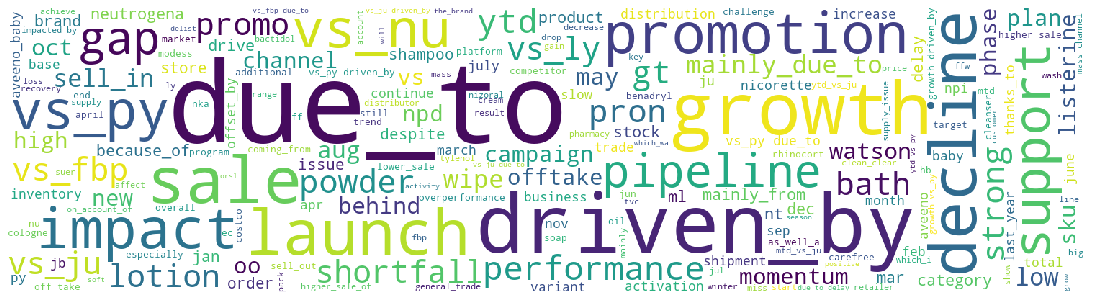

In [17]:
clean_comments_all = comment_preprocessing(comments)
string_all = list_to_string(clean_comments_all)
wordcloud = WordCloud(width = 1500, height = 400, 
                        background_color ='white', 
                        #stopwords = stopwords, 
                        min_font_size = 10).generate(string_all) 
plt.figure(figsize = (15, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

##### Across Years

Observations: 
* 2017 comments focus on JU, FBP & PY; while 2018 has significant NU & PY comparison

sent_to_words took=0:00:00
make_trigrams took=0:00:00.371026
lemmatization took=0:00:36.431652
remove_stopwords took=0:00:00.135360
comment_preprocessing took=0:00:37.480488
list_to_string took=0:00:00.673969
sent_to_words took=0:00:00
make_trigrams took=0:00:00.363980
lemmatization took=0:00:34.076258
remove_stopwords took=0:00:00.215206
comment_preprocessing took=0:00:35.021368
list_to_string took=0:00:01.840907
wordcloud_ready took=0:01:15.028768


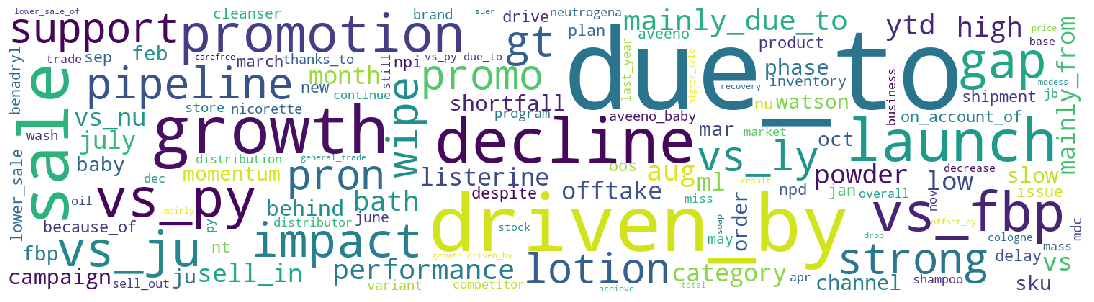

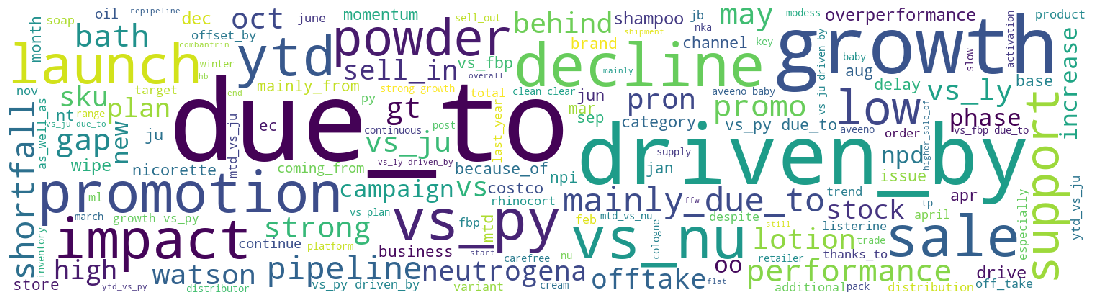

In [18]:
Year_comments = wordcloud_ready(group_by_column = 'Year', dataset = deduplicated_data.sort_values(by=['Year']))
#2017, 2018
word_cloud_print(Year_comments)

##### Across comparisons

Observations: 
* This is a clear confirmation that the sorting has worked - among most prominent words in each cloud are vs_fbp, vs_ju, vs_nu, vs_py in that order
* Nothing significantly different is observed

sent_to_words took=0:00:00
make_trigrams took=0:00:00.169451
lemmatization took=0:00:13.134019
remove_stopwords took=0:00:00.047125
comment_preprocessing took=0:00:13.531066
list_to_string took=0:00:00.092369
sent_to_words took=0:00:00
make_trigrams took=0:00:00.175500
lemmatization took=0:00:15.109285
remove_stopwords took=0:00:00.061206
comment_preprocessing took=0:00:15.529437
list_to_string took=0:00:00.248629
sent_to_words took=0:00:00
make_trigrams took=0:00:00.153407
lemmatization took=0:00:13.278255
remove_stopwords took=0:00:00.052099
comment_preprocessing took=0:00:13.613115
list_to_string took=0:00:00.089274
sent_to_words took=0:00:00
make_trigrams took=0:00:00.423129
lemmatization took=0:00:25.564559
remove_stopwords took=0:00:00.108286
comment_preprocessing took=0:00:26.441138
list_to_string took=0:00:00.497325
wordcloud_ready took=0:01:10.053388


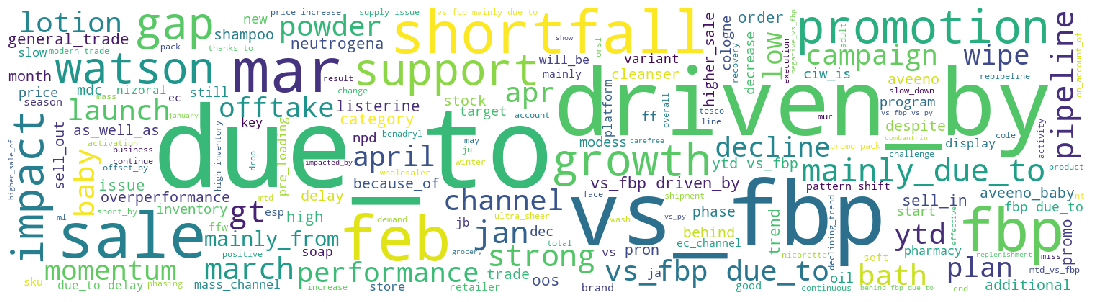

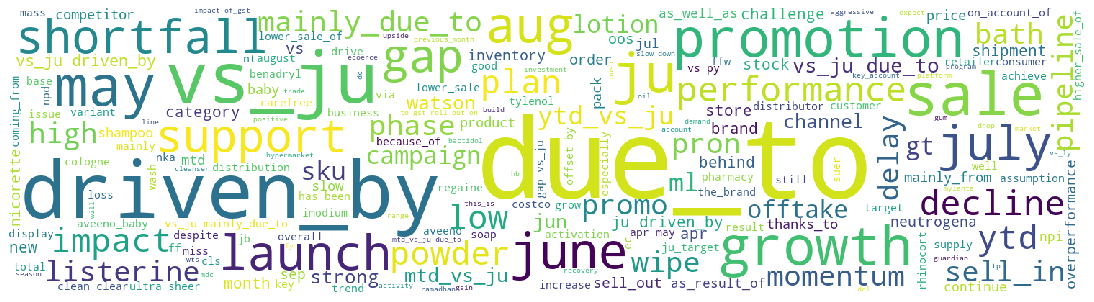

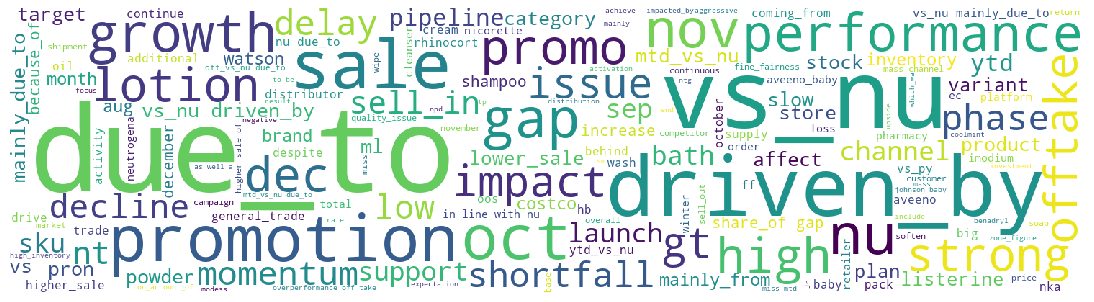

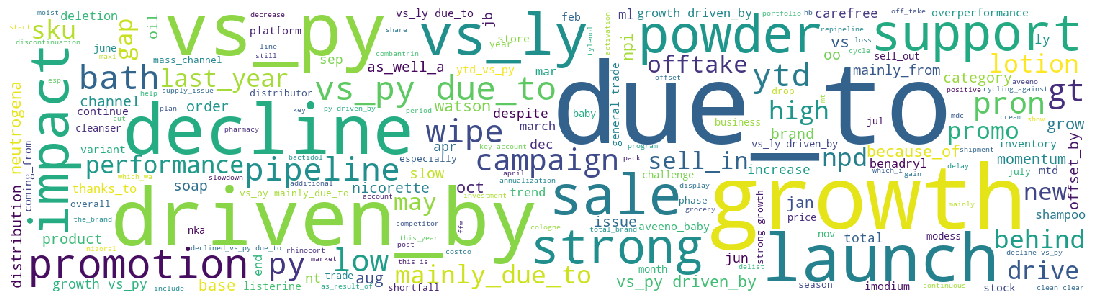

In [19]:
Comparitive_comments = wordcloud_ready(group_by_column = 'Comparitive', dataset = deduplicated_data.sort_values(by=['Comparitive']))
#FBP, JU, NU, PY
word_cloud_print(Comparitive_comments)

##### Across Periods

Observations:
* Although this observation could be an anomaly due to lower number of QTD commentaries, it would seem that QTD is much more focused on reporting growth numbers rather than getting too much into the detail of 'which' product. Words like 'sale', 'momentum','decline', 'support', 'promotion', 'campaign' seem to be very prominent. The QTD report looks to be a commentary with slightly different focus compared to YTD/MTD.
* The element of launch of products seem to be prominent for 'YTD' commentaries compared to other commentaries (words like 'launch in', 'npd' etc.). There are commentaries with launch in MTD as well, but npd seems to be exclusive language for YTD
    * NPD stands for new product development

sent_to_words took=0:00:00
make_trigrams took=0:00:00.371992
lemmatization took=0:00:27.753223
remove_stopwords took=0:00:00.106313
comment_preprocessing took=0:00:28.814085
list_to_string took=0:00:00.443183
sent_to_words took=0:00:00
make_trigrams took=0:00:00.061201
lemmatization took=0:00:04.709406
remove_stopwords took=0:00:00.024068
comment_preprocessing took=0:00:04.854796
list_to_string took=0:00:00.014073
sent_to_words took=0:00:00
make_trigrams took=0:00:00.396030
lemmatization took=0:00:35.407675
remove_stopwords took=0:00:00.264706
comment_preprocessing took=0:00:36.457452
list_to_string took=0:00:01.438866
wordcloud_ready took=0:01:12.033418


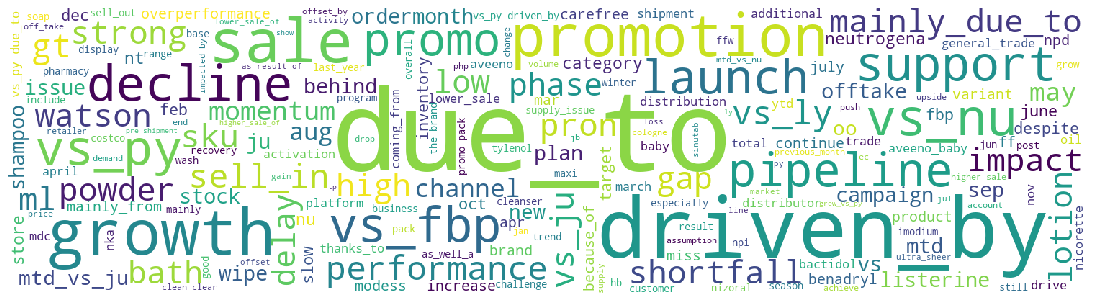

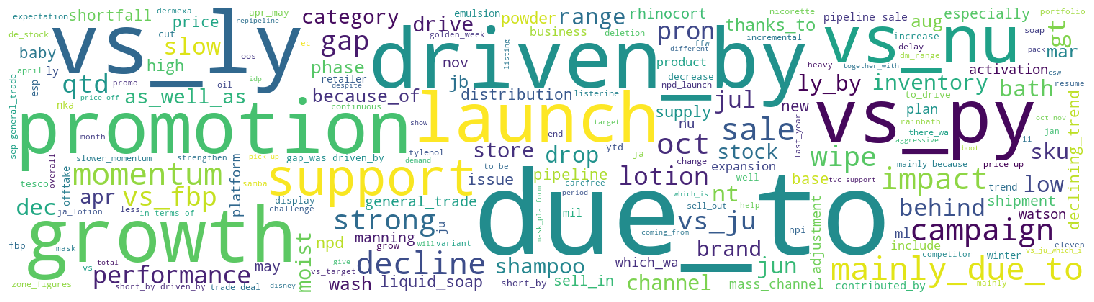

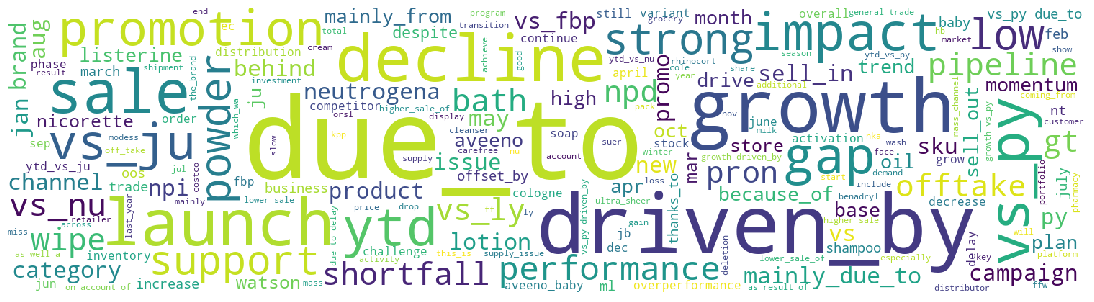

In [20]:
Period_comments = wordcloud_ready(group_by_column = 'Period Type', dataset = deduplicated_data.sort_values(by=['Period Type']))
# MTD, QTD, YTD
word_cloud_print(Period_comments)

##### Across Months

Observations:
* The primary purpose of this word-cloud was to check if the language changes as commentaries move across the year or if there are significant changes in commentary as we jump quarters - that does NOT seem to be the case!

sent_to_words took=0:00:00
make_trigrams took=0:00:00.039105
lemmatization took=0:00:03.672792
remove_stopwords took=0:00:00.048130
comment_preprocessing took=0:00:03.816174
list_to_string took=0:00:00.017044
sent_to_words took=0:00:00
make_trigrams took=0:00:00.243648
lemmatization took=0:00:04.878300
remove_stopwords took=0:00:00.017047
comment_preprocessing took=0:00:05.333542
list_to_string took=0:00:00.012038
sent_to_words took=0:00:00
make_trigrams took=0:00:00.054144
lemmatization took=0:00:04.640235
remove_stopwords took=0:00:00.020052
comment_preprocessing took=0:00:04.764867
list_to_string took=0:00:00.014037
sent_to_words took=0:00:00
make_trigrams took=0:00:00.083180
lemmatization took=0:00:06.248663
remove_stopwords took=0:00:00.035091
comment_preprocessing took=0:00:06.427137
list_to_string took=0:00:00.031083
sent_to_words took=0:00:00
make_trigrams took=0:00:00.133356
lemmatization took=0:00:05.730314
remove_stopwords took=0:00:00.023059
comment_preprocessing took=0:00:

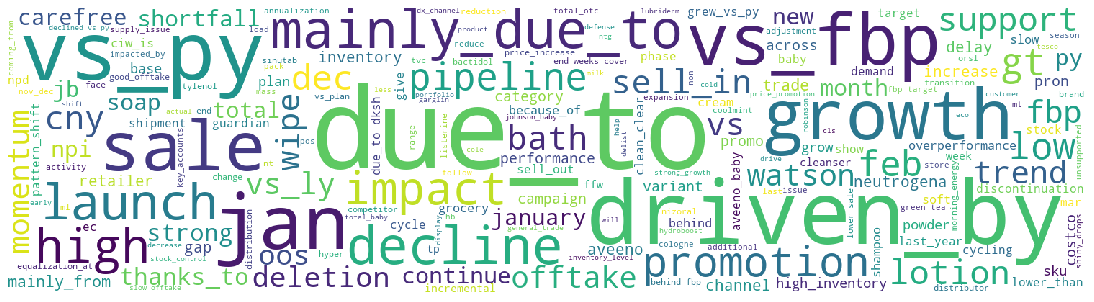

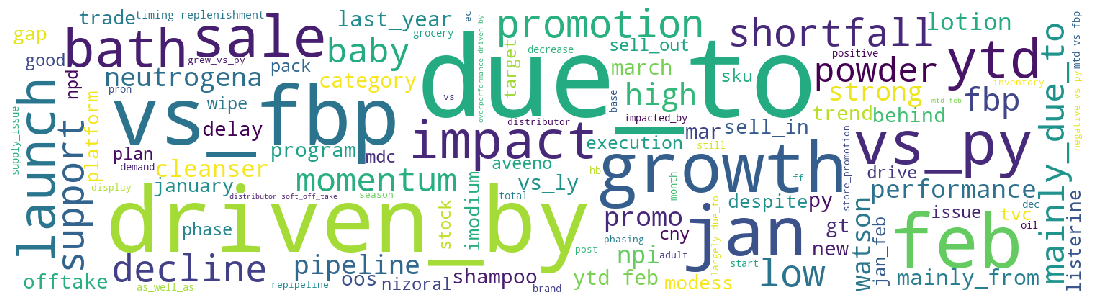

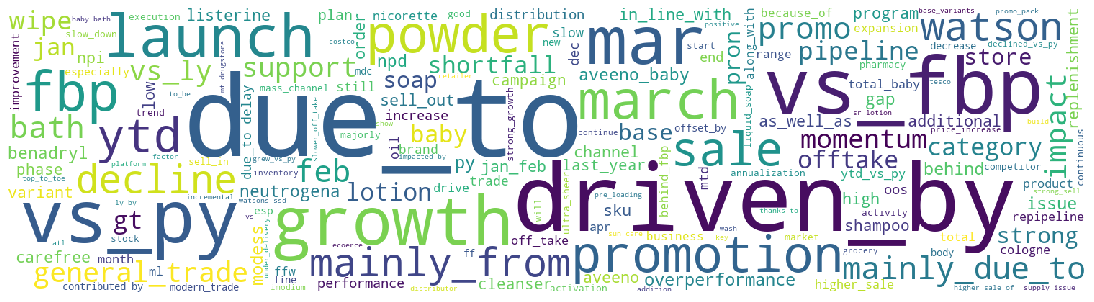

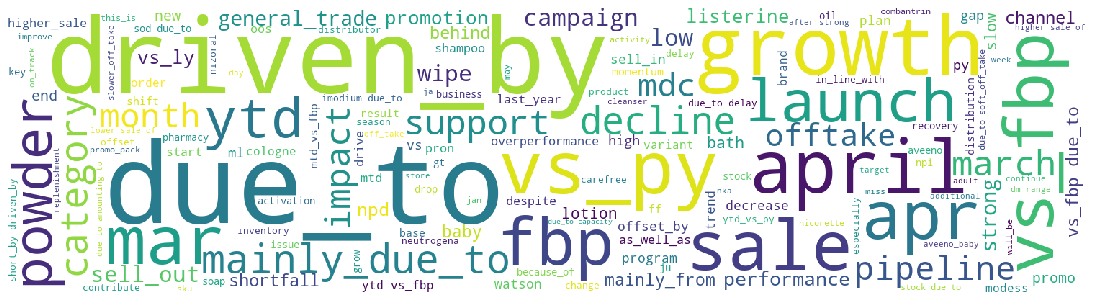

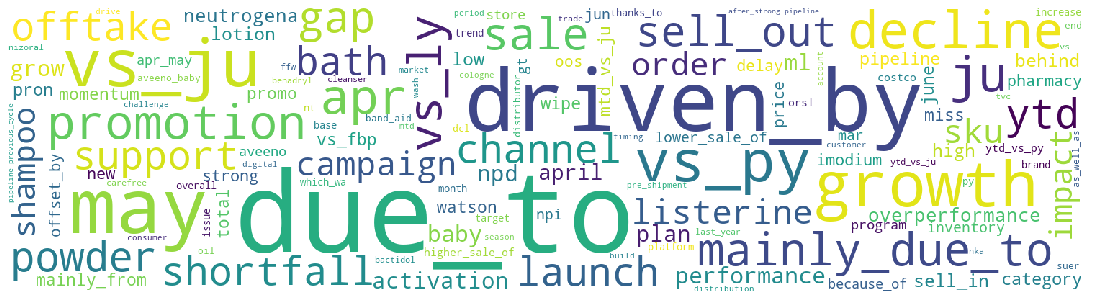

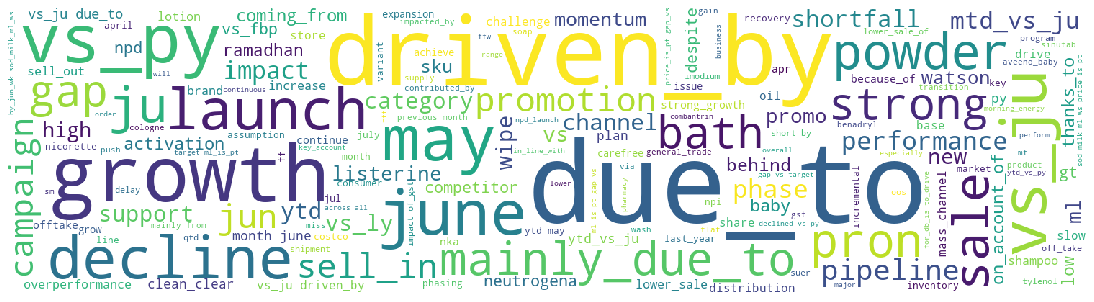

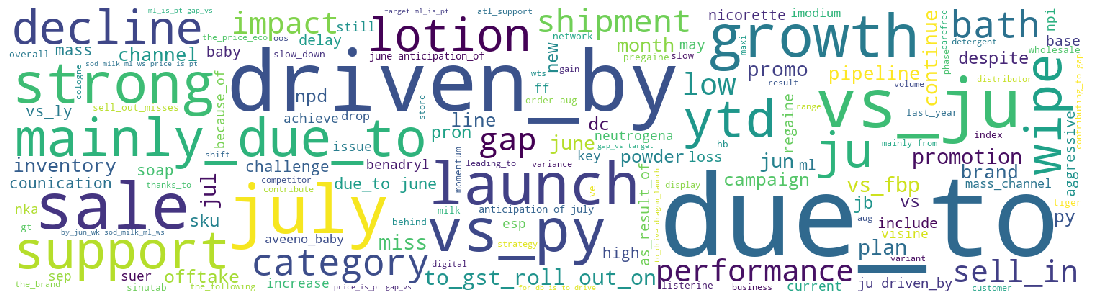

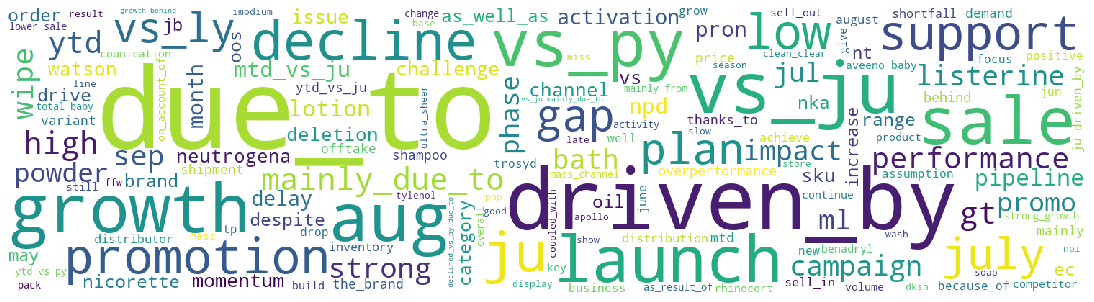

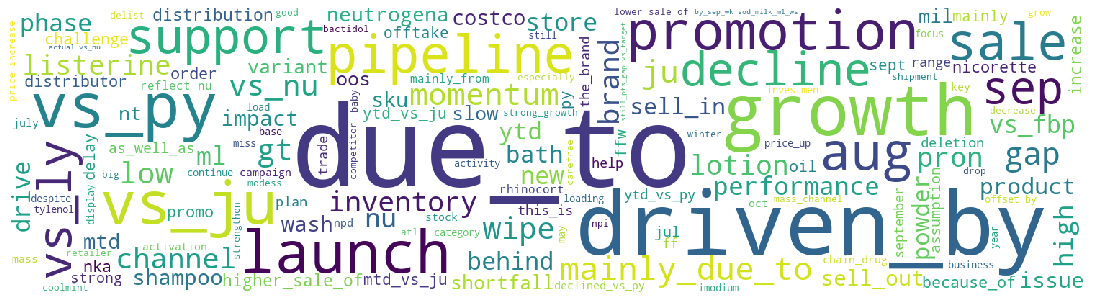

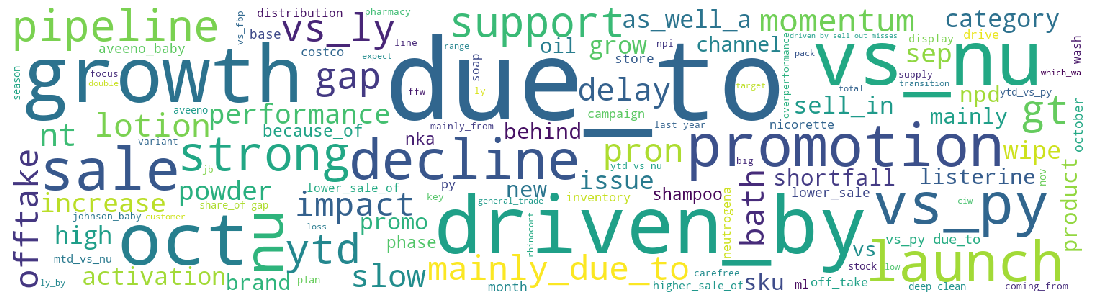

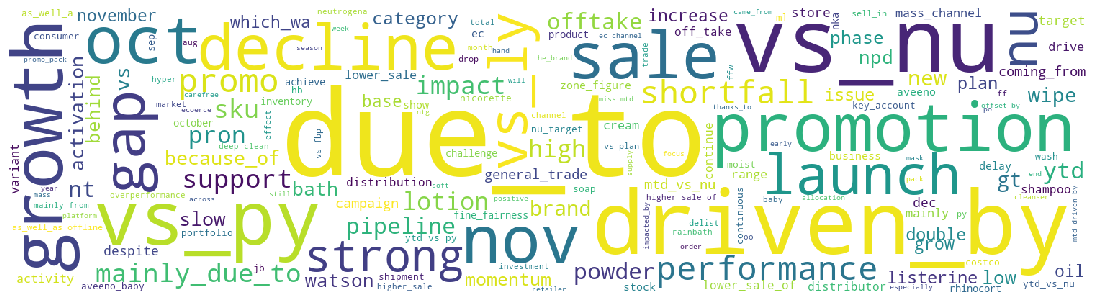

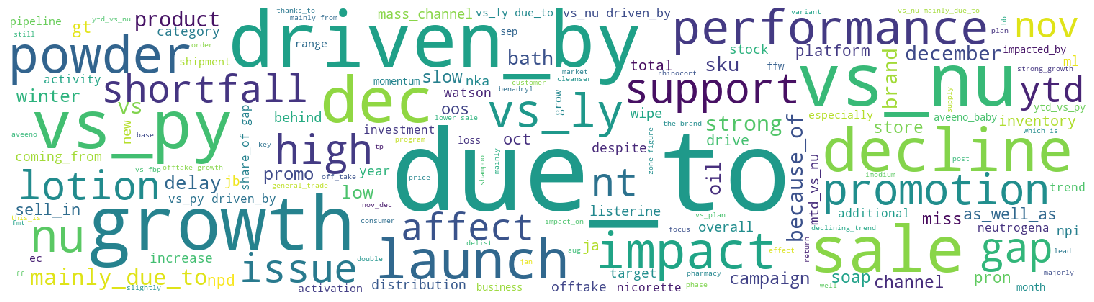

In [21]:
Month_comments = wordcloud_ready(group_by_column = 'Month', dataset = deduplicated_data.sort_values(by=['Month']))
word_cloud_print(Month_comments)

### NLTK Token Analysis

In [22]:
import nltk
#nltk.download('treebank')
#nltk.download('universal_tagset')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.text import Text

C:\Users\uchaturv\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\uchaturv\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict


In [23]:
sentences = deduplicated_data['Comment'].str.cat(sep = ' ')
sentences = sentences.lower()
sentences = '"' + sentences + '"'
text = word_tokenize(sentences)
nltk_text = Text(text)

In [24]:
# Lexical Diversity - i.e. number of distinct words out of all the words
len(set(nltk_text)) / len(nltk_text) 
## Only 3.45% of the words in the entire corpus are unique

0.034539085693430005

In [25]:
print("Similar words to due: ")
nltk_text.similar('due')
print("Similar words to mainly: ")
nltk_text.similar('mainly')
print("Similar words to launch: ")
nltk_text.similar('launch')
print("Similar words to driven: ")
nltk_text.similar('driven')
print("Similar words to growth: ")
nltk_text.similar('growth')
print("Similar words to decline: ")
nltk_text.similar('decline')
print("Similar words to sale: ")
nltk_text.similar('sale')
print("Similar words to promotion: ")
nltk_text.similar('promotion')
print("Similar words to promo: ")
nltk_text.similar('promo')
print("Similar words to gap: ")
nltk_text.similar('gap')
print("Similar words to support: ")
nltk_text.similar('support')
print("Similar words to impact: ")
nltk_text.similar('impact')
print("Similar words to offset: ")
nltk_text.similar('offset')
print("Similar words to impact: ")
nltk_text.similar('impact')

Similar words to due: 
thanks compared leading continues owing from contributed continue
contributing resulting led in back delay top unable is lead support
expected
Similar words to mainly: 
py is ju fbp shortfall by growth nu ly decline was target
underperformance gap coming primarily largely majorly and of
Similar words to launch: 
pipeline launched decline npd phasing deletion underperformance growth
overperformance oos delisting sales delay start shipment availability
gap momentum performance softening
Similar words to driven: 
offset impacted contributed caused short supported py ly fbp declined
ju target is mainly by grew led mitigated came was
Similar words to growth: 
performance decline momentum py shortfall fbp sales ju
underperformance is mainly offtake gap overperformance pipeline nu in
trend slowdown promotion
Similar words to decline: 
growth gap shortfall underperformance mainly overperformance is py
performance increase ffw fbp pipeline oos drop promotion delay powder


In [26]:
sentences_pos = nltk.pos_tag(text, tagset='universal')
word_tag_fd = nltk.FreqDist(sentences_pos)

In [27]:
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'NOUN']

['%',
 'py',
 'growth',
 'performance',
 'support',
 'channel',
 'ju',
 'trade',
 'promotion',
 'inventory',
 'sales',
 'fbp',
 'momentum',
 'baby',
 'sale',
 'impact',
 'campaign',
 'launch',
 'ly',
 'decline',
 'gap',
 'brand',
 'ytd',
 'care',
 'lotion',
 'bath',
 'nu',
 'issue',
 'price',
 'powder',
 'pipeline',
 'distribution',
 'shortfall',
 'platform',
 'category',
 'range',
 'offtake',
 'wipes',
 'soap',
 'underperformance',
 'base',
 'year',
 'promo',
 'expansion',
 'oil',
 'stock',
 'plan',
 'listerine',
 'season',
 'skus',
 'target',
 'jb',
 'gt',
 'mtd',
 'business',
 'month',
 'q1',
 'mass',
 'c',
 'correction',
 'trend',
 'thanks',
 'supply',
 'issues',
 'activation',
 'shampoo',
 'b',
 'distributor',
 ']',
 'line',
 'nts',
 'pack',
 'display',
 'mask',
 'vs.',
 'cream',
 '+',
 'figures',
 'consumption',
 'sell-in',
 'sell',
 'investment',
 'market',
 'phasing',
 'brands',
 'watsons',
 'variants',
 'china',
 'pharmacy',
 'share',
 'winter',
 'overperformance',
 'aveeno',


In [28]:
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'ADJ']

['due',
 'strong',
 'lower',
 '+',
 'higher',
 'total',
 'new',
 'general',
 'high',
 'slower',
 'last',
 'low',
 'positive',
 'key',
 'soft',
 'in-store',
 'off-take',
 'operational',
 'good',
 'competitive',
 'negative',
 'slow',
 'nu',
 'aveeno',
 'overall',
 'healthy',
 'unsupported',
 'free',
 'npd',
 'ec',
 'heavy',
 'better',
 'clean',
 'deep',
 'sell-in',
 'aggressive',
 'baby',
 'short',
 'ytd',
 'fbp',
 'less',
 'additional',
 'atl',
 'digital',
 'dry',
 'listerine',
 'clear',
 'coentary',
 'incremental',
 'neutrogena',
 'continuous',
 'other',
 'q1',
 'sell-out',
 'previous',
 'gt',
 'carefree',
 'retail',
 'nizoral',
 'natural',
 'inventory',
 'mtd',
 'ultra',
 'double',
 'organic',
 'effective',
 'tp',
 'active',
 'wholesale',
 ']',
 'such',
 'fine',
 'softer',
 'continued',
 'shiny',
 'offtake',
 'white',
 'stable',
 'npi',
 'regular',
 'full',
 'early',
 'impact',
 'category',
 'cold',
 'fresh',
 'poor',
 'nov',
 'sensitive',
 'more',
 'modern',
 'q4',
 'unrealized',
 'p

In [29]:
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'VERB']

['driven',
 'is',
 'was',
 'offset',
 'expected',
 'has',
 'may',
 'be',
 'phasing',
 'coming',
 'contributed',
 'grew',
 'been',
 'are',
 '+',
 'launched',
 'offtake',
 'including',
 'declined',
 'came',
 'impacted',
 'will',
 'missed',
 'slow',
 'have',
 'declining',
 'were',
 'drive',
 'planned',
 'had',
 'underperformed',
 'increased',
 'delayed',
 'continued',
 'growing',
 'overperformed',
 'caused',
 'sell',
 'led',
 'coupled',
 'impacting',
 'cut',
 'continues',
 'clearing',
 'building',
 'given',
 'affecting',
 'reduced',
 'achieved',
 'leading',
 'resulting',
 'did',
 'shifting',
 'toe',
 'supply',
 'aveeno',
 'cycling',
 'gst',
 'overdelivered',
 'grow',
 'ensure',
 'comes',
 'reflected',
 'based',
 'softening',
 'supported',
 'driving',
 'slower',
 'sustained',
 'ytd',
 'decline',
 'continue',
 'resulted',
 'being',
 'brought',
 'build',
 'starting',
 '’',
 'improved',
 'mtd',
 'helped',
 'compared',
 'showed',
 'built',
 'py',
 'shortfall',
 'delisting',
 'lower',
 'mention

In [30]:
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'ADV']

['mainly',
 'partially',
 'also',
 'well',
 'as',
 'not',
 'especially',
 'still',
 'nu',
 'ahead',
 'majorly',
 'however',
 'where',
 'ytd',
 'slightly',
 'primarily',
 "n't",
 'yet',
 'back',
 'forward',
 'largely',
 'only',
 'up',
 'further',
 'more',
 'particularly',
 'earlier',
 'better',
 'together',
 'down',
 'marginally',
 'continuously',
 'lower',
 'very',
 'significantly',
 'july',
 'even',
 'out',
 'enough',
 'currently',
 'already',
 'respectively',
 'thus',
 'fully',
 'due',
 'mostly',
 'partly',
 'now',
 'approximately',
 'additionally',
 'so',
 'less',
 'when',
 'almost',
 'fast',
 '+',
 'aggressively',
 'driven',
 'heavily',
 'most',
 'turnover',
 'closely',
 'close',
 'newly',
 'nka',
 'higher',
 'npds',
 'later',
 'faster',
 'externally',
 'upside',
 'instead',
 'consistently',
 'biore',
 'strongly',
 'off',
 'highly',
 'npi',
 'npd',
 'prior',
 'in-store',
 'specifically',
 'negatively',
 'originally',
 'aveeno',
 'apart',
 'gradually',
 'sucessfully',
 'nhi',
 'clos

In [31]:
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'CONJ']

['and',
 '&',
 'but',
 'ytd',
 'plus',
 'nicorette',
 'or',
 'nu',
 'tylenol',
 'neu',
 '/',
 'npd',
 'yet',
 'lqtr',
 'ssd',
 'less',
 'neutrogena',
 'labo',
 '-0.4',
 'npi',
 '/+0.2',
 'b',
 'ntd',
 'antuss',
 '/+122.8m',
 '/+24m',
 '/+23.5m',
 'lubriderm',
 '+20',
 'imc',
 '*cls',
 'mat',
 'mylanta',
 '+',
 'aneton',
 '/+0.1',
 '/+0.3',
 '/+26m',
 'both',
 'apr',
 'b.',
 '+0.1',
 '/+56m',
 '/+57m',
 'mdc',
 '+21.5',
 '+22.6',
 '-4',
 '/+0.510',
 '/+0.084',
 'ii/display',
 'wash',
 '-neu',
 'npds',
 '+2.3',
 '+2.6',
 '+0.7',
 '/+0.1m',
 '/+0.3m',
 '/+0.5m',
 '/+0.02m',
 '/+0.01m',
 '-non-ttt',
 '/+1.6',
 'trosyd',
 '/+0.7',
 '/+1.5',
 'patten',
 '-tp',
 '+0.07',
 '-0.36m',
 '-0.68',
 '+6.3',
 'ec',
 '/+1.1',
 'ya',
 'smooth',
 '/+1.4',
 '-2.3',
 'aveeno',
 '+4.0',
 '+0.4m/+15.5',
 '-2.7',
 'nka',
 '-0.1',
 'nov',
 'nov.']

In [32]:
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'DET']

['the',
 'a',
 'which',
 'this',
 'all',
 'both',
 'no',
 'that',
 'there',
 'an',
 'these',
 'some',
 'any',
 'another',
 'neutrogena',
 'nu',
 'each',
 'ffw',
 '*small',
 'sustain',
 'wipes',
 'biore',
 'nicorette',
 'either',
 'nursery',
 'ytd',
 'h2']

### Topic Modeling 

Topic modeling was done to check whether the language can distinguish between 3 types of topics that I hope exist:

* Reporting numbers only at product group level and generic statements (i.e. Baby powder went down by x%)
* Reporting numbers that dig a bit deeper into the data i.e. goes down maybe a level or 2 to report what caused the movement (i.e. Baby Powder went up by y% due to strong growth in Minor 1 and Minor 2, offset by Minor 3)
* Commentaries that are made from insights through BU-F and for which data is NOT present in consumer sales (i.e. Baby powder continued its growth momentum due to XXXX campaign and YYYY sale)

So, the expectation is 3 topics - we will be checking using perplexity score

The results should be at the end of this section

In [41]:
#import nltk

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['listerine', 'powder', 'bath', 'soap', 'shampoo', 'baby','feb', 'mar', 'oct', 'aveeno_baby', 'neutrogena', 'lotion'])

@log
def topic_modeling_data(data = deduplicated_data):
    r"""
    
    Create the dictonary for topic modeling
    
    Parameters
    ----------
    data = dataframe
    
    Returns
    -------
    lda model data
    """
    comments_list = data.Comment.values.tolist()
    data_lemmatized = comment_preprocessing(comments_list)
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    id2word.filter_extremes(no_below=30, no_above=0.50)
    id2word.compactify()

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    return texts, id2word, corpus

In [42]:
#Getting data for LDA model
final_data, id2word, corpus =  topic_modeling_data()

sent_to_words took=0:00:00
make_trigrams took=0:00:01.454897
lemmatization took=0:02:41.942594
remove_stopwords took=0:00:00.970115
comment_preprocessing took=0:02:46.037723
topic_modeling_data took=0:02:46.420908


In [43]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=1000,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

print(lda_model.print_topics())
doc_lda = lda_model[corpus]
doc_lda

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.044*"vs_py" + 0.028*"growth" + 0.028*"mainly_due_to" + 0.025*"vs_fbp" + 0.019*"vs_ju" + 0.017*"due_to" + 0.015*"launch" + 0.015*"ytd" + 0.015*"strong" + 0.014*"vs_nu"'), (1, '0.076*"due_to" + 0.045*"driven_by" + 0.022*"growth" + 0.016*"sale" + 0.016*"decline" + 0.012*"launch" + 0.010*"vs_py" + 0.010*"shortfall" + 0.010*"pipeline" + 0.010*"impact"'), (2, '0.056*"due_to" + 0.032*"promotion" + 0.032*"driven_by" + 0.023*"support" + 0.022*"vs_ly" + 0.021*"wipe" + 0.019*"brand" + 0.017*"momentum" + 0.017*"general_trade" + 0.015*"gap"')]

Perplexity:  -5.639195044058

Coherence Score:  0.35306661918050003


In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.004124 -0.157513       1        1  56.980713
0     -0.166617  0.075796       2        1  24.793695
2      0.162493  0.081717       3        1  18.225592, topic_info=              Term         Freq        Total Category  logprob  loglift
5            vs_py   759.000000   759.000000  Default  30.0000  30.0000
107      driven_by  1422.000000  1422.000000  Default  29.0000  29.0000
31       promotion   489.000000   489.000000  Default  28.0000  28.0000
9           due_to  2576.000000  2576.000000  Default  27.0000  27.0000
89   mainly_due_to   410.000000   410.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
39       thanks_to    64.772728   132.070435   Topic3  -4.8392   0.9899
35           stock    60.793587   145.312286   Topic3  -4.9026   0.8309
24         channel    64.351746   251.325562   Topic3  -4.8457   0.3400
56          launch    66.559982   539.170593   Topic3  -4.8120  -0.3896
88          impact    60.037731   375.096191   Topic3  -4.9151  -0.1299

[208 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
393       1  0.073462  activation
393       2  0.928294  activation
317       1  0.344271         apr
317       2  0.602474         apr
317       3  0.052965         apr
...     ...       ...         ...
296       1  0.491665         ytd
296       2  0.419288         ytd
296       3  0.089847         ytd
349       1  0.140159   ytd_vs_py
349       2  0.860980   ytd_vs_py

[325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [27]:
##### Best number of topics based on coherent score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    r"""
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=1000,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=final_data, start=2, limit=10, step=1)

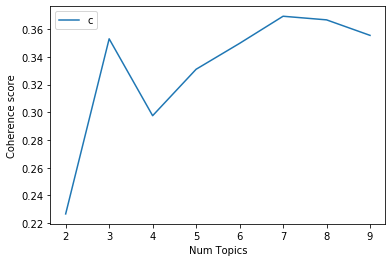

In [34]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
# 3 looks to be a good number of topics for the dataset

Num Topics = 2  has Coherence Value of 0.2267
Num Topics = 3  has Coherence Value of 0.3531
Num Topics = 4  has Coherence Value of 0.2976
Num Topics = 5  has Coherence Value of 0.3311
Num Topics = 6  has Coherence Value of 0.3498
Num Topics = 7  has Coherence Value of 0.3694
Num Topics = 8  has Coherence Value of 0.3667
Num Topics = 9  has Coherence Value of 0.3555


**Concluding Observations**

* The topic models are unable to differentiate the commentaries in terms of language and purpose of a commentary
    * The splits occur along the lines of frequently occurring words in a manner contrary to what was required e.g. (due_to and mainly_due_to) go to different topics and so does (vs_fbp and vs_ju). While different topics here make sense in terms of addressing different comparative periods or different infections of language (such as stressing upon something), they do not meet our primary purpose of being able to identify the 3 different types of topics we set out to differentiate
* Various configurations were attempted in terms of #topics, minimum and maximum threshold of words/phrases allowed as well as introducing new stopwords (primarily to stop frequently occurring product names and months)
    * The most coherent grouping observed were with the configuration of no_below=30, no_above=0.50 and the most extensive list of stopwords

### Word-to-vector 

This was done to check whether words we perceive as similar actually do appear in a similar context in language!!

In [226]:
from gensim.models import Word2Vec

@log
def word2vec(comments):
    #final_words = comment_preprocessing(comments)
    data = [re.sub(r'\s+', ' ', sent) for sent in comments]
    words = list(sent_to_words(data))
    trigram_words = make_trigrams(words)
    #final_words = lemmatization(trigram_words)
    #final_words = remove_stopwords(trigram_words)
    comment2vec = Word2Vec(trigram_words, 
                           size=50, # vector size
                           window=3, # n-gram window
                           min_count=30, # minimum count of a word in the corpus
                           sg=1,         # use a skip-gram Word2Vec model rather than Continuous Bag of Words (CBOW) ## IMPORTANT TO HIGHLIGHT - n-gram understands the context!!
                           alpha = 0.05, # initial learning rate
                           min_alpha = 0.00001, #final minimized learning rate)
                           seed=1,
                           iter = 50, #training epochs
                           negative = 5
                          )
    
    comment2vec.save(os.path.join(os.getcwd(), 'word2vec_model_all'))
    return comment2vec

In [267]:
comment2vec = word2vec(comments)

#print(u'{} training epochs so far.'.format(comment2vec.train_count))
print(u'{:,} terms in the food2vec vocabulary.'.format(len(comment2vec.wv.vocab)))

sent_to_words took=0:00:00
make_trigrams took=0:00:01.298636
word2vec took=0:00:11.503975
594 terms in the food2vec vocabulary.


In [268]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
comment2vec.init_sims()
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in comment2vec.wv.vocab.items()]
#print(ordered_vocab)

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda vocab: -vocab[2])
#print(ordered_vocab)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the terms as row labels
word_vectors = pd.DataFrame(comment2vec.wv.syn0norm[term_indices, :],
                            index=ordered_terms)

word_vectors

C:\Users\uchaturv\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  app.launch_new_instance()


0         1         2         3         4   \
in                       -0.198378  0.444214  0.066961  0.004623  0.018401   
and                      -0.391862  0.397960 -0.086109  0.109062 -0.000034   
of                       -0.250710  0.314669 -0.061975 -0.035085  0.106780   
due_to                   -0.242683  0.328266 -0.023507 -0.048009  0.057005   
the                      -0.280297  0.277188 -0.133141  0.045081  0.056423   
...                            ...       ...       ...       ...       ...   
there_is                 -0.001051  0.176789 -0.048270 -0.025751  0.278794   
lower_than_expected_sell  0.167900  0.028471 -0.063770 -0.002132  0.286415   
impacting                -0.269363  0.115088  0.015932  0.077095  0.046635   
boots                     0.073896 -0.052234  0.135118 -0.016118 -0.000327   
china                    -0.035843 -0.009995  0.004503 -0.113856  0.022617   

                                5         6         7         8         9   \
in                        0.090623  0.091719  0.066393  0.058342  0.090050   
and                       0.008521  0.121448  0.040809  0.166845 -0.008035   
of                        0.045254  0.193869  0.222080  0.073008  0.137205   
due_to                    0.011216  0.083218  0.298337  0.042505  0.076908   
the                       0.071492  0.144783  0.027073 -0.084482  0.175467   
...                            ...       ...       ...       ...       ...   
there_is                  0.113005  0.079272 -0.015439 -0.167365 -0.070515   
lower_than_expected_sell  0.112733 -0.027760 -0.061741 -0.141612 -0.078428   
impacting                -0.104093 -0.068434 -0.071012 -0.075301  0.279272   
boots                     0.052217  0.048127 -0.326062  0.092103 -0.095671   
china                    -0.247400  0.114120  0.178457 -0.017991  0.004411   

                          ...        40        41        42        43  \
in                        ...  0.097442 -0.256158 -0.014061 -0.160557   
and                       ...  0.054091 -0.133587 -0.032791 -0.189291   
of                        ...  0.109315 -0.091265  0.027456 -0.211856   
due_to                    ...  0.017802 -0.163192  0.061439 -0.137215   
the                       ...  0.145406 -0.215739 -0.032713 -0.317896   
...                       ...       ...       ...       ...       ...   
there_is                  ...  0.049158  0.040087 -0.085194  0.083786   
lower_than_expected_sell  ... -0.084501 -0.094158 -0.068772 -0.006651   
impacting                 ... -0.176470  0.129349 -0.113868  0.096826   
boots                     ... -0.126696  0.088209 -0.028653 -0.303233   
china                     ...  0.131292 -0.161387 -0.236462 -0.258085   

                                44        45        46        47        48  \
in                        0.192498 -0.014492 -0.052082 -0.131925 -0.055520   
and                       0.038575  0.003519 -0.050495 -0.058899  0.055125   
of                        0.216601  0.076108 -0.015894  0.082678 -0.053900   
due_to                    0.003506  0.115732 -0.149836 -0.161524 -0.020974   
the                       0.329118 -0.023209  0.067241 -0.014672 -0.082260   
...                            ...       ...       ...       ...       ...   
there_is                  0.060957 -0.131591  0.210200 -0.007490 -0.071889   
lower_than_expected_sell -0.019795 -0.011489 -0.196203 -0.146486  0.109269   
impacting                 0.312703  0.082135  0.040969 -0.198465 -0.002929   
boots                    -0.051558  0.240039  0.222965 -0.070796 -0.126579   
china                     0.252253  0.068094  0.024684  0.310758 -0.035604   

                                49  
in                       -0.046685  
and                      -0.070243  
of                        0.033120  
due_to                    0.218492  
the                      -0.236935  
...                            ...  
there_is                 -0.048834  
lower_than_expected_sell -0.119409  
impacting  

#### Word Algebra & Similarity

In [224]:
def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """
    
    for word, similarity in comment2vec.wv.most_similar(positive=[token], topn=topn):
        print(u'{:20} {}'.format(word, round(similarity, 3)))

In [272]:
get_related_terms('oct')

nov                  0.712
sep                  0.635
dec                  0.514
vs_nu                0.455
sept                 0.434
shipment             0.41
no                   0.408
nu                   0.395
ecoerce_channel      0.394
mar                  0.392


In [273]:
get_related_terms('baby')

bath                 0.591
cream                0.529
baby_oil             0.517
share                0.499
oil                  0.495
shampoo              0.472
lotion               0.436
cologne              0.435
continued            0.417
powder               0.415


In [276]:
get_related_terms('vs_ju')

vs_fbp               0.708
vs_py                0.677
vs_nu                0.661
mtd                  0.525
vs_ly                0.509
primarily            0.505
ju                   0.477
target               0.464
upside               0.442
ytd_vs_ju            0.415


In [270]:
get_related_terms('due_to')

of                   0.73
driven_by            0.723
and                  0.707
in                   0.695
from                 0.659
mainly_driven_by     0.571
for                  0.547
by                   0.544
with                 0.543
mainly_due_to        0.466


In [271]:
get_related_terms('mainly_due_to')

mainly_driven_by     0.595
by                   0.562
cls                  0.479
is_mainly_driven     0.467
due_to               0.466
was                  0.46
sep                  0.449
npd                  0.435
mainly_from          0.428
from                 0.426


In [227]:
## Final model
comment2vec = Word2Vec.load(os.path.join(os.getcwd(), 'word2vec_model_all_final'))
comment2vec.init_sims()

#### Playground for Word2vec

In [278]:
get_related_terms('promo')

price_increase       0.499
promos               0.499
oos                  0.487
promo_packs          0.477
ww                   0.475
promotional          0.466
ly                   0.452
one                  0.444
promotion            0.44
sell_in              0.433


In [279]:
get_related_terms('sale')

lower_sale           0.635
on_account_of        0.622
of_gst               0.603
ultra_sheer          0.546
driven_by_lower_sale 0.541
higher_sale_of       0.538
orsl                 0.524
higher_sale          0.506
sales                0.503
lower_sale_of        0.493


In [280]:
get_related_terms('promotion')

tesco                0.576
from                 0.531
hyper                0.505
in                   0.464
to                   0.46
more                 0.455
retailer             0.45
with                 0.443
promo                0.44
sell_in              0.415


In [318]:
get_related_terms('growth')

strong_growth        0.575
growing              0.533
grew                 0.475
is                   0.475
brand                0.435
strong_off_take      0.431
overall              0.422
vs_ly                0.421
trend                0.419
flat                 0.418


In [319]:
get_related_terms('decline')

impact               0.51
affecting            0.492
effect               0.476
impacted_by          0.463
soap                 0.452
impacted             0.45
powder               0.435
however              0.429
promos               0.429
cycling              0.42


In [228]:
get_related_terms('impact')

decline              0.51
effect               0.503
impact_on            0.471
before               0.444
was                  0.438
trade                0.437
costco               0.431
cls                  0.429
powder               0.418
ecoerce_channel_business_issue 0.412


In [296]:
def word_algebra(add=[], subtract=[], topn=1):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = comment2vec.wv.most_similar(positive=add, negative=subtract, topn=topn)
    
    for term, similarity in answers:
        print(term)

In [302]:
word_algebra(add=[u'vs_nu', u'jul'],subtract = [u'oct'])

vs_ju


In [308]:
word_algebra(add=[u'vs_py', u'feb'],subtract = [u'py'])

vs_fbp


## Sales Data Exploration

### More Data Wrangling

In [34]:
# Determining Hierarchy

Region_columns = ['Country']
@log
def hierarchy_finder(sales_data, Region_columns = Region_columns):
    r"""
    
    Given a conusmer sales file with certain "Region columns", certian "Product Hierarchy" columns and NTS data, finds the product hierarchy and geographic hierarchy
    
    Parameters
    ----------
    Data-Frame: Consumer Sales Data
    Region_columns = list or str of data specifying the columns which are of region type
    
    Returns
    -------
    product_hierarchy, region_hierarchy
        lists with products and regions sorted by hierarchy
    
    """
    #Removing NTS columns
    Columns_to_remove = sales_data.columns[sales_data.columns.str.match('NTS')]
    # Removing period column as well
    Columns_to_remove = Columns_to_remove.append(pd.Index(['Period']))
    Region_columns = sales_data[Region_columns].columns
    
    ## Hierarchy for products
    Columns_to_remove = Columns_to_remove.append(Region_columns)
    Filtered_data = sales_data.drop(columns = Columns_to_remove)
    print("Columns on which product hierarchy will be tested are:", Filtered_data.columns)
    
    # Figuring out the hierarchy
    hierarchy_columns = Filtered_data.columns
    product_hierarchy_list = []
    
    if len(hierarchy_columns) > 1:
        for combinations in itertools.permutations(hierarchy_columns, 2):
            print("Combination is: ", combinations)
            temp_h1 = combinations[0]
            temp_h2 = combinations[1]
            temp_data = Filtered_data.groupby(temp_h1)[temp_h2].nunique()
            #print(temp_data)
            if np.any(temp_data > 1):
                print(temp_h1, "is above", temp_h2, "in hierarchy." )
                product_hierarchy_list.append(combinations)
            else:
                print(temp_h1, "is NOT above", temp_h2, "in hierarchy." )
        
        product_hierarchy_dataframe = pd.DataFrame(product_hierarchy_list, columns = ['Upper_h','Lower_h'])
        product_hierarchy = list(product_hierarchy_dataframe.Upper_h.value_counts().index)
        product_hierarchy_lower = product_hierarchy_dataframe.Lower_h.value_counts().index[0]
        product_hierarchy.append(product_hierarchy_lower)
        print("Product hierarchy from the data is:", product_hierarchy)
    else:
        print("Only 1 column detected - that is the only hierarchy available")
        product_hierarchy = [hierarchy_columns.values[0]] 
    
    ## Hierarchy for Region
    #Columns_to_remove = Columns_to_remove.append(Region_columns)
    Filtered_data = sales_data[Region_columns]
    print("Columns on which regional hierarchy will be tested are:", Filtered_data.columns)
    
    # Figuring out the hierarchy
    hierarchy_columns = Filtered_data.columns
    region_hierarchy_list = []
    
    if len(hierarchy_columns) > 1:
        for combinations in itertools.permutations(hierarchy_columns, 2):
            print("Combination is: ", combinations)
            temp_h1 = combinations[0]
            temp_h2 = combinations[1]
            temp_data = Filtered_data.groupby(temp_h1)[temp_h2].nunique().sort()
            if np.any(temp_data > 1):
                print(temp_h1, "is above", temp_h2, "in hierarchy." )
                region_hierarchy_list.append(combinations)
            else:
                print(temp_h1, "is NOT above", temp_h2, "in hierarchy." )
        
        region_hierarchy_dataframe = pd.DataFrame(region_hierarchy_list, columns = ['Upper_h','Lower_h'])
        region_hierarchy = list(region_hierarchy_dataframe.Upper_h.value_counts().index)
        region_hierarchy_lower = region_hierarchy_dataframe.Lower_h.value_counts().index[0]
        region_hierarchy.append(region_hierarchy_lower)
        print("Region hierarchy from the data is:", product_hierarchy)
    else:
        print("Only 1 column detected - that is the only hierarchy available", hierarchy_columns.values)
        region_hierarchy = [hierarchy_columns.values[0]] 
    
    ## ASSUMPTION 1: REGIONAL HIERARCHY WILL ALWAYS BE ABOVE PRODUCT HIERARCHY
    ## i.e say a hierarchy of (country_cluster -> country -> region) will always precede (FL1 -> FL2 -> SKU)
    overall_hierarchy = region_hierarchy + product_hierarchy
    return region_hierarchy, overall_hierarchy

# This dataset is taken as an example
sales_2018 = pd.read_csv(r'Consumer Sales Data 2018.csv')
region_hierarchy, overall_hierarchy = hierarchy_finder(sales_2018)

## ASK USER TO CONFIRM BOTH THE HIERARCHIES
print("The overall hierarchy is (in descending order): ", overall_hierarchy, "and regional hierarchy is:", region_hierarchy)

Columns on which product hierarchy will be tested are: Index(['SKU', 'FranchiseLevel2', 'FranchiseLevel1'], dtype='object')
Combination is:  ('SKU', 'FranchiseLevel2')
SKU is NOT above FranchiseLevel2 in hierarchy.
Combination is:  ('SKU', 'FranchiseLevel1')
SKU is NOT above FranchiseLevel1 in hierarchy.
Combination is:  ('FranchiseLevel2', 'SKU')
FranchiseLevel2 is above SKU in hierarchy.
Combination is:  ('FranchiseLevel2', 'FranchiseLevel1')
FranchiseLevel2 is NOT above FranchiseLevel1 in hierarchy.
Combination is:  ('FranchiseLevel1', 'SKU')
FranchiseLevel1 is above SKU in hierarchy.
Combination is:  ('FranchiseLevel1', 'FranchiseLevel2')
FranchiseLevel1 is above FranchiseLevel2 in hierarchy.
Product hierarchy from the data is: ['FranchiseLevel1', 'FranchiseLevel2', 'SKU']
Columns on which regional hierarchy will be tested are: Index(['Country'], dtype='object')
Only 1 column detected - that is the only hierarchy available ['Country']
hierarchy_finder took=0:00:00.047139
The overal

In [35]:
@log
def consumer_sales_data(sales_df = sales_2018):
    r"""
    
    Manipulates Consumer data to long format
    
    Parameters
    ----------
    sales_df = Consumer sales Data in wide format
    
    Returns
    -------
    Dataframe = sales data in long format
    
    """
    print("Sales data is of the shape: ", sales_df.shape)

    # Removing spaces from column names to ensure long to wide conversion
    sales_df.columns = sales_df.columns.str.replace(' ','')
    wide_to_long_LHS_list = overall_hierarchy.copy()
    wide_to_long_LHS_list.append('Period')
    sales_concat_longformat = pd.wide_to_long(sales_df,stubnames='NTS', i = wide_to_long_LHS_list, 
                                              j = 'Comparision_period', suffix=r'\w+')
    sales_concat_longformat.reset_index(drop = False, inplace = True) 

    # Seperating month and comparision period columns
    sales_concat_longformat['Period Type'] = sales_concat_longformat['Comparision_period'].str[3:]
    sales_concat_longformat['Period Type'] = sales_concat_longformat['Period Type'].str.replace("", 'MTD')
    sales_concat_longformat['Period Type'] = sales_concat_longformat['Period Type'].str.replace('MTDQMTDTMTDDMTD', 'QTD')
    sales_concat_longformat['Period Type'] = sales_concat_longformat['Period Type'].str.replace('MTDYMTDTMTDDMTD', 'YTD')
    sales_concat_longformat['Month'] = sales_concat_longformat['Comparision_period'].str[:3]
    print("Sales table after converting it to long format is of dimensions: ", sales_concat_longformat.shape)

    # Getting correct comparitives
    sales_concat_longformat["Plan"] = sales_concat_longformat["Period"].str[:-5]
    sales_concat_longformat["Plan"] = sales_concat_longformat["Plan"].str.replace(" ","")

    #sales_concat_longformat["Plan"] = sales_concat_longformat["Plan"].str.replace

    sales_concat_longformat.drop(columns = ['Comparision_period'], inplace = True)
    return sales_concat_longformat

#final_sales_data = consumer_sales_data(sales_df = sales_2018)
#final_sales_data

In [389]:
## Next Step is to create a full fleged dataset at the level Period (YTD, QTD, MTD) - Comparision - Month - Year - Country - Product (The valid ones) and map it to Clean_dataset above to understand when commentaries are necessary and when they are not

@log
def create_fulldataset():
    r"""
    
    Creates a data-frame that gives all possible combinations of commentaries possible
    
    Parameters
    ----------
    None
    
    Returns
    -------
    Dataframe
    
    """
    Period_dict = {'Period Type': ['YTD', 'MTD', 'QTD'], 'Key': 1}
    df_period = pd.DataFrame(Period_dict)
    df = df_period.merge(pd.DataFrame({'Comparitive': ['FBP', 'JU', 'NU', 'PY'],'Key': 1}), how = 'outer') \
        .merge(pd.DataFrame({'Month_key':[1,2,3,4,5,6,7,8,9,10,11,12], 
                         'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                                      'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
                         ,'Key': 1}),how = 'outer' )
    
    # To prevent retrospective calculations (like JU available in January!!), these rows will be removed
    df = df[~((df['Comparitive'] == 'JU') & (df['Month_key']<4))] #JU available from April (normally)
    df = df[~((df['Comparitive'] == 'NU') & (df['Month_key']<9))] #NU available after mid-August (normally)
    
            #.merge(pd.DataFrame({'Country': ['China OTC', 'Vietnam', 'Taiwan', 'Hong Kong', 'Indonesia',
         #                                   'Japan', 'Korea', 'Thailand', 'Malaysia', 'China Skincare', 
          #                                  'Singapore', 'India', 'Philippines', 'APSC', 'China Skin', 
           #                                'Pacific'],'Key': 1}), how = 'outer') \
            
    return df

### Calculations from Consumer Sales data - General
* Will need multiple rules for tackling exceptions

In [37]:
## Product Level of hierarchy of commentary generation ['Country', 'FranchiseLevel1', 'FranchiseLevel2', 'SKU']
commentary_hierarchy = 'FranchiseLevel2'

# Filters, if required
#Year = 0
Month = 'All'    #Jan - Dec
#Country = 'All'  #from list of countries
Plan = 'All'     #[FBP, JU, NU, ACT(PY)]
Period_type = 'All' #MTD, QTD, YTS

In [9]:
# function that filters and rolls up lower hierarchy datadata
def lower_hierarchy_calculations(index, conditions, hierarchy_dictionary):
    r"""

    Filters, rolls up and calculates required data
    
    Parameters
    ----------
    index: index of for loop 
    conditions 
    sales_df_lower_hierarchy: sales data rolled-up to a hierarchy below the level at which commentary is required
    
    Returns
    -------
    lower_level_dict: dictionary with entity, value and percentage value! In v2, 3rd level hierarchy values can be added as dict entities as well
    #lists of entity, value and percentages of lower level hierarchy values
    
    period_type, month, hierarchy, regional_hierarchy,plan
    """
    # Dictionaries where data will be stored
    data = {}
    
    if len(conditions) == 4: # No region hierarchy in this data 
        period_type = conditions[0]
        month = conditions[1]
        hierarchy = conditions[2]
        plan = conditions[3]
    
        current_condition = (sales_data_rolledup_h2.Period_Type == period_type) & \
                                                       (sales_data_rolledup_h2.Month == month) & \
                                                       (sales_data_rolledup_h2[hierarchy_dictionary['h_1']] == hierarchy)
        
        filtered_data = sales_data_rolledup_h2[current_condition]
        
        for product in filtered_data[filtered_data['Plan'] == 'ACT'][hierarchy_dictionary['h_2']].unique(): #Loop over only the product-groups with actual sales this year
            comparative_value = filtered_data[(filtered_data.Plan == plan) & (filtered_data[hierarchy_dictionary['h_2']] == product)].NTS.values
            actual_value = filtered_data[(filtered_data.Plan == 'ACT') & (filtered_data[hierarchy_dictionary['h_2']] == product)].NTS.values
            
            if (comparative_value.size != 0) & (actual_value.size != 0):
                actual_value = actual_value[0]
                comparative_value = comparative_value[0]
                
                diff = (actual_value - comparative_value)/1000000
                perc = ((actual_value - comparative_value)/abs(comparative_value)) * 100

                if (abs(diff) >= 0.1)|(abs(perc) > 14.5):

                    ## Storing these values in dictionary
                    data[product] = [diff, perc]
        
        return data
        
    if len(conditions) == 5: # With region hierarchy 
        period_type = conditions[0]
        month = conditions[1]
        hierarchy = conditions[2]
        regional_hierarchy = conditions[3]
        plan = conditions[4]
        
        current_condition = (sales_data_rolledup_h2.Period_Type == period_type) & \
                                                       (sales_data_rolledup_h2.Month == month) & \
                                                       (sales_data_rolledup_h2[region_hierarchy[-1]] == regional_hierarchy) & \
                                                       (sales_data_rolledup_h2[hierarchy_dictionary['h_1']] == hierarchy)
        
        filtered_data = sales_data_rolledup_h2[current_condition]
        
        
        for product in filtered_data[filtered_data['Plan'] == 'ACT'][hierarchy_dictionary['h_2']].unique(): #Loop over only the product-groups with actual sales this year
            comparative_value = filtered_data[(filtered_data.Plan == plan) & (filtered_data[hierarchy_dictionary['h_2']] == product)].NTS.values
            actual_value = filtered_data[(filtered_data.Plan == 'ACT') & (filtered_data[hierarchy_dictionary['h_2']] == product)].NTS.values
            
            if (comparative_value.size != 0) & (actual_value.size != 0):
                actual_value = actual_value[0]
                comparative_value = comparative_value[0]
                
                diff = (actual_value - comparative_value)/1000000
                perc = ((actual_value - comparative_value)/abs(comparative_value)) * 100

                if (abs(diff) >= 0.1)|(abs(perc) > 14.5):
                    ## Storing these values in dictionary
                    data[product] = [diff, perc]
                    
        return data
        
# Creating a function that filters the full dataset according to required parameters and aggregates it to the required level of commentary

def commentary_calculations(sales_df, commentary_hierarchy, Month, Plan, Period_type):
    
    global sales_data_rolledup_h2 ##Making lower level hierarchy dataset global so that this dataset doen't need to be called everytime 'lower_hierarchy_calculations' is called
    r"""

    Filters the full dataset according to required parameters and brings it to the required level
    
    Parameters
    ----------
    commentary_hierarchy, Month, Plan, Period Type
    sales_df: sales data in the input format provided to Analytics team - wide format
    
    Returnss
    -------
    Dataframe
    
    """
    
    # Checking if 'commentary hierarchy entered is part of overall hierarchy'
    if commentary_hierarchy not in overall_hierarchy:
        print("You have specified a hierarchy not part of the overall hierarchy provided! Program will exit")
        return None
    
    # Importing conusmer data
    sales_data = consumer_sales_data(sales_df = sales_df)
    
    
    # Filtering for required conditions
    if(Month != 'All'):
        sales_data = sales_data[sales_data['Month'] == Month]
    
    if(Period_type != 'All'):
        sales_data = sales_data[sales_data['Period Type'] == Period_type]

    #if(Country != 'All'):
     #   sales_data = sales_data[sales_data['Country'] == Country]

    if(Plan != 'All'):
        sales_data = sales_data[(sales_data['Plan'] == Plan) | (sales_data['Plan'] == 'ACT')]
        if(Plan == 'ACT'):
            Plan_alternate == 'PY'
            print("Caution! You will be comparing against PY Actuals!")
    
    if sales_data.shape[0] == 0:
        print("One of the filters entered does not exist, please check the value of the filter!")
        return None
            
    # Position of required roll-up in hierarchy
    number_of_hierarchies = len(overall_hierarchy) - (overall_hierarchy.index(commentary_hierarchy)+1)
    print("There are",number_of_hierarchies, "product hierarchies below the level of commentary generation")
    
    # Dictionary storing the hierarchy values
    if number_of_hierarchies == 0:
        print("You are generating commentaries at a very low product group hierarchy. Please move up atleast 1 hierarchy")
        return None
    else:
        hierarchy_dict = {}
        i = 0
        ## WE WILL NOT GO BELOW 3 LEVELS OF HIERARCHY FOR ANY COMMENTARY
        while i<=number_of_hierarchies:
            key = 'h_' + str(i+1)  #h = hierarchy with 1 starting from the top
            value = overall_hierarchy[i-number_of_hierarchies-1]
            hierarchy_dict[key] = value
            i += 1
            if i == 3:
                break
        
        #Get an empty template
        df_empty = create_fulldataset()
        
        # Filtering empty template according to conditions
        if(Month != 'All'):
            df_empty = df_empty[df_empty['Month'] == Month]
    
        if(Period_type != 'All'):
            df_empty = df_empty[df_empty['Period Type'] == Period_type]

        #if(Country != 'All'):
         #   sales_data = sales_data[sales_data['Country'] == Country]

        if(Plan != 'All'):
            if Plan == 'ACT':
                df_empty = df_empty[df_empty['Comparitive'] == 'PY']
            else:
                df_empty = df_empty[df_empty['Comparitive'] == Plan]
        
        ## If df_empty(the template) has a filter that causes problems, return None (Mailny applied for 'Plan' filter which was causing problems)
        if df_empty.shape[0] == 0:
            print("One of the filters entered does not exist, please check the value of the filter!")
            return None
        
        ## Rolling up procedures
        Current_year = sales_data['Period'].str[-4:].unique().max()
        Current_year_actual = str('ACT ' + Current_year)
        Last_year = str(int(sales_data['Period'].str[-4:].unique().max()) - 1)
        Last_year_actual = str('ACT ' + Last_year) #For finding actual values of last year data
        
        # Template for commentaries
        df_hierarchy = sales_data[sales_data['Period'] == Current_year_actual]  # template only for products where actual data for current year is present
        df_hierarchy = df_hierarchy[overall_hierarchy[:overall_hierarchy.index(commentary_hierarchy)+1]] ## All columns with hierarchies above (and including required) are joined
        df_hierarchy.drop_duplicates(inplace = True)
        df_hierarchy['Key'] = 1
        all_commentaries_df = df_empty.merge(df_hierarchy, how = 'outer', on = 'Key') ## This join ensures the integrity of certain products in certain countries
        all_commentaries_df.columns = all_commentaries_df.columns.str.replace(' ','_')
        all_commentaries_df.drop(columns = ['Key'], inplace = True)
        print("Commentary template is of the shape:", all_commentaries_df.shape)
        #df_commentary_values = all_commentaries_df.copy()
        
        
        # Rolling up data
        ## Lower level hierarchy values - h2 hierarchy
        groupby_list_h2 = ['Period', 'Period Type', 'Month', 'Plan'] + overall_hierarchy[:overall_hierarchy.index(commentary_hierarchy)+2]
        sales_data_rolledup_h2 = sales_data.groupby(groupby_list_h2)[['NTS']].sum().reset_index(drop = False)
        print("Lower level hierarchy roll-up successful")
        sales_data_rolledup_h2['Plan'] = np.where(sales_data_rolledup_h2['Period'] == Last_year_actual, 'PY',sales_data_rolledup_h2['Plan'])
        sales_data_rolledup_h2.columns = sales_data_rolledup_h2.columns.str.replace(' ','_')

        ## Commentary level roll-up
        groupby_list = ['Period', 'Period_Type', 'Month', 'Plan'] + overall_hierarchy[:overall_hierarchy.index(commentary_hierarchy)+1]
        sales_data_rolledup = sales_data_rolledup_h2.groupby(groupby_list)[['NTS']].sum().reset_index(drop = False)
        print("Commentary level hierarchy roll-up successful")
        

        ## Getting required values of data
        out_v = [] #value output
        out_p = [] #percentage output
        remark = [] # remarks on comparitive
        lower_hierarchy_dict = {}
        if commentary_hierarchy not in region_hierarchy:
            for index, row in all_commentaries_df.iterrows():
                
                period_type = row.Period_Type
                month = row.Month
                regional_hierarchy = row[str(region_hierarchy[-1])]
                hierarchy = row[hierarchy_dict['h_1']]
                plan = row.Comparitive

                condition = (sales_data_rolledup.Period_Type == period_type) & \
                                                       (sales_data_rolledup.Month == month) & \
                                                       (sales_data_rolledup[region_hierarchy[-1]] == regional_hierarchy) & \
                                                       (sales_data_rolledup[hierarchy_dict['h_1']] == hierarchy) 

                filter_df = sales_data_rolledup[condition]

                comparative_value = filter_df[filter_df.Plan == plan].NTS.values
                actual_value = filter_df[filter_df.Plan == 'ACT'].NTS.values
                

                if ((comparative_value.size == 0) | (actual_value.size == 0)):
                    value = 0
                    percentage = 0
                    rem = pd.Series("Comparative value not found")
                else:
                    comparative_value = comparative_value[0]
                    actual_value = actual_value[0]
                    
                    ## Calling hierarchy level 2 function
                    lower_hierarchy_calc = lower_hierarchy_calculations(index = index, 
                                                         conditions = [period_type, month, hierarchy, regional_hierarchy,plan], 
                                                         hierarchy_dictionary = hierarchy_dict)
                    lower_hierarchy_dict[index] = lower_hierarchy_calc
                    
                    
                    # Commentary level calculations
                    if comparative_value == 0:
                        percentage = 0
                        value = (actual_value-comparative_value)/1000000
                        rem = pd.Series("Comparitive value is 0 - Percentage calculation not possible")
                    elif (comparative_value<0) | (actual_value < 0):
                        percentage = ((actual_value-comparative_value)/abs(comparative_value)) * 100
                        value = (actual_value-comparative_value)/1000000
                        rem = pd.Series("Negative actual or planned values detected")
                    else:
                        percentage = ((actual_value-comparative_value)/abs(comparative_value)) * 100
                        value = (actual_value-comparative_value)/1000000
                        rem = pd.Series("None")
                
                if index%5000 == 0:
                    print(index)

                out_p.append(percentage)
                out_v.append(value)
                remark.append(rem.values[0])
        else:
            for index, row in all_commentaries_df.iterrows():
                period_type = row.Period_Type
                month = row.Month
                #regional_hierarchy = row[region_hierarchy[-1]]
                hierarchy = row[hierarchy_dict['h_1']]
                plan = row.Comparitive

                condition = (sales_data_rolledup.Period_Type == period_type) & \
                                                       (sales_data_rolledup.Month == month) & \
                                                       (sales_data_rolledup[hierarchy_dict['h_1']] == hierarchy) 

                filter_df = sales_data_rolledup[condition]

                comparative_value = filter_df[filter_df.Plan == plan].NTS.values
                actual_value = filter_df[filter_df.Plan == 'ACT'].NTS.values
                
                
                if ((comparative_value.size == 0) | (actual_value.size == 0)):
                    value = 0
                    percentage = 0
                    rem = pd.Series("Comparative value not found")
                else:
                    ## Calling hierarchy level 2 function
                    lower_hierarchy_calc = lower_hierarchy_calculations(index = index, 
                                                         conditions = [period_type, month, hierarchy,plan], 
                                                         hierarchy_dictionary = hierarchy_dict)
                    lower_hierarchy_dict[index] = lower_hierarchy_calc
                    
                    
                    # Commentary level calculations
                    comparative_value = comparative_value[0]
                    actual_value = actual_value[0]
                    
                    if comparative_value == 0:
                        percentage = 0
                        value = (actual_value-comparative_value)/1000000
                        rem = pd.Series("Comparitive value is 0 - Calculation not possible")
                    elif (comparative_value<0) | (actual_value < 0):
                        percentage = ((actual_value-comparative_value)/abs(comparative_value)) * 100
                        value = (actual_value-comparative_value)/1000000
                        rem = pd.Series("Negative actual or planned values detected")
                    else:
                        percentage = ((actual_value-comparative_value)/abs(comparative_value)) * 100
                        value = (actual_value-comparative_value)/1000000
                        rem = pd.Series("None")
                if index%5000 == 0:
                    print(index)

                out_p.append(percentage)
                out_v.append(value)
                remark.append(rem.values[0])
        
        # Appending values to dataframe
        #out_p = pd.Series()
        all_commentaries_df['h_1_value'] = out_v #pd.Series(out_v).values
        all_commentaries_df['h_1_percentage'] = out_p
        all_commentaries_df['Remarks'] = remark
        return lower_hierarchy_dict, all_commentaries_df
        #print(all_commentaries_df)

#lower_hierarchy_claculation, commentaries_calculation_2018 = commentary_calculations(sales_df = sales_2018, commentary_hierarchy = commentary_hierarchy, Month = Month, Plan = Plan, Period_type = Period_type)    

In [20]:
sales_df = pd.read_csv(r'Consumer Sales Data 2018.csv')

lower_hierarchy_calculation, commentaries_calculation = commentary_calculations(sales_df = sales_df, commentary_hierarchy = commentary_hierarchy, Month = Month, Plan = Plan, Period_type = Period_type)    

In [207]:

## Saving files above
commentaries_calculation.to_csv("FranchiseLevel2_Commentary_calculation_2018.csv")

import pickle
with open('lower_hierarchy_FranchiseLevel2_2018.pickle', 'wb') as handle:
    pickle.dump(lower_hierarchy_calculation, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('lower_hierarchy_FranchiseLevel2_2018.pickle', 'rb') as handle:
    lower_hierarchy_calculation = pickle.load(handle)

In [ ]:
sales_df = pd.read_csv(r'Consumer Sales Data 2018.csv')
commentary_calculations(sales_df = sales_df, commentary_hierarchy = 'Country', Month = 'Jan', Plan = 'FBP', Period_type = 'QTD')

In [ ]:
commentary_calculations(sales_df = sales_2018, commentary_hierarchy = 'FranchiseLevel2', Month = 'Oct', Plan = 'All', Period_type = 'All')

## Some Insights & Observations/Findings

### Boxplots to understand where commentary has been written

In [10]:
def sales_mapping():    
    r""" sales_mapping
    
    Reads the sales mapping file (to consumer sales data) created by the author for 2017 and 2018 product groups used in commentaries
    
    Parameters
    ----------
    None
    
    Returns
    -------
    2 data frames for 2017 and 2018 which can be mapped to corresponding commentary files and then to commentary calculation data (from section above)
        
    """
    
    mapping_file = pd.read_csv(r"Mapping_file_commentary_to_sales.csv")
    mapping_products = mapping_file[['Product (From Commentary)','Remarks', 'Level (From Sales)' ,'Mapping (From Sales 2017)', 'Mapping (From Sales 2018)']]
    mapping_products = mapping_products[mapping_products['Remarks'] != 'Ignored']
    mapping_products.rename(columns = {'Product (From Commentary)' : 'Commentary_Product_Group', 
                                       'Remarks' : 'Remarks', 
                                       'Level (From Sales)' : 'Product_Group_Level',
                                       'Mapping (From Sales 2017)' : 'Sales_to_Comment_2017_product_mapping',
                                       'Mapping (From Sales 2018)' : 'Sales_to_Comment_2018_product_mapping'}, inplace = True)
    mapping_products_2017 = mapping_products[['Commentary_Product_Group', 'Product_Group_Level', 'Sales_to_Comment_2017_product_mapping']]
    mapping_products_2018 = mapping_products[['Commentary_Product_Group', 'Product_Group_Level', 'Sales_to_Comment_2018_product_mapping']]
    
    return mapping_products_2017, mapping_products_2018

mapping_products_2017, mapping_products_2018 = sales_mapping()

In [11]:
comparitivemap = """ACT 2017 vs FBP 2017|FBP
ACT 2017 vs ACT 2016|PY
ACT 2017 vs ACT 2015|Ignore
ACT 2017 vs JU 2017|JU
ACT 2017 vs NU 2017|NU
ACT 2018 vs FBP 2018|FBP
ACT 2018 vs ACT 2017|PY
FBP 2018 vs ACT 2017|Ignore
ACT 2018 vs JU 2018|JU
ACT 2018 vs JU 2017|Ignore
ACT 2018 vs NU 2018|NU
ACT 2018 vs NU 2017|Ignore"""
comparitive = {}
for x in comparitivemap.split("\n"):
    comparitive[x.split("|")[0]] = x.split("|")[1]
    

def commentary_mapping_for_analysis(mapping_file, commentary_calculation_file, commentary_file):
    r""" 
    
    Takes in the commentary calculation file (created from sales data by author) and the commentary file (provided beforehand) and merges it together using the mapping file
    
    Parameters
    ----------
    None
    
    Returns
    -------
    2 data frames for 2017 and 2018 which can be mapped to corresponding commentary files and then to commentary calculation data (from section above)
        
    """
    
    mapping_file = mapping_file[mapping_file['Product_Group_Level'] == 'Franchise Level 2']
    commentary_file["Comparative"] = commentary_file["Version"].apply(lambda x : comparitive[x])
    # Cleaning up
    print("Original commentary file:", commentary_file.shape)
    commentary_file = commentary_file[commentary_file['Comment'].notna()] 
    commentary_file = commentary_file[(commentary_file['Comment']!= '0') | (commentary_file['Comment']!= 'NA')] 
    print("Commentary file after cleaning up:", commentary_file.shape)
    # Merging with mapping file
    commentary_file = commentary_file.merge(mapping_file, how = 'inner', left_on = 'Product', right_on = 'Commentary_Product_Group')
    print("Commentary file after inner-join with mapping file (Only FranchiseLevel2 products considered):", commentary_file.shape)
    
    # Left joining the commentary calculation file with the commentary file
    commentary_calculation_file = commentary_calculation_file[commentary_calculation_file['Remarks'] != 'Comparative value not found']
    
    if any(commentary_file['Year'] == 2018):
        merged_file = commentary_calculation_file.merge(commentary_file, how = 'left', left_on = ['FranchiseLevel2','Period_Type', 'Comparitive', 'Month_key', 'Country'], 
                                                   right_on = ['Sales_to_Comment_2018_product_mapping', 'Period Type', 'Comparative', 'Month', 'Country'])
    if any(commentary_file['Year'] == 2017):
        merged_file = commentary_calculation_file.merge(commentary_file, how = 'left', left_on = ['FranchiseLevel2','Period_Type', 'Comparitive', 'Month_key', 'Country'], 
                                                   right_on = ['Sales_to_Comment_2017_product_mapping', 'Period Type', 'Comparative', 'Month', 'Country'])    
    
    # Some comments are lost as comment is written but no corresponding data is available
    print("Number of comments in merged file are:", merged_file['Comment'].count(), "out of", len(merged_file), "showing that comments have been written in only", 
          (merged_file['Comment'].count()/len(merged_file) *100), "% of all possible comparatives across all products.")
    
    return merged_file

In [12]:
#2018 commentary calculation file
commentary_calculations_2018 = pd.read_csv(r'FranchiseLevel2_Commentary_calculation_2018.csv')
commentary_calculations_2018.drop(columns = 'Unnamed: 0', inplace = True)
# Reading commentary data
commentary_2018 = pd.read_csv(r'Consumer Sales Commentary 2018_Annotated.csv')
commentary_2018['Year'] = 2018

# Calling merging function
merged_2018_file = commentary_mapping_for_analysis(mapping_file = mapping_products_2018, commentary_calculation_file = commentary_calculations_2018, commentary_file = commentary_2018)
merged_2018_file

print("If we accepted the thresholds given of 15%/$0.5MM, there are", len(merged_2018_file[(abs(merged_2018_file['h_1_value']) >= 0.5) | 
                                                                                           (abs(merged_2018_file['h_1_percentage']) >= 15) ]),
      "commentary candidates WITHOUT counting the candidates which show large movement at lower hierarchies")

Original commentary file: (5101, 8)
Commentary file after cleaning up: (4906, 8)
Commentary file after inner-join with mapping file (Only FranchiseLevel2 products considered): (4110, 11)
Number of comments in merged file are: 3608 out of 26086 showing that comments have been written in only 13.831173809706357 % of all possible comparatives across all products.
If we accepted the thresholds given of 15%/$0.5MM, there are 16506 commentary candidates WITHOUT counting the candidates which show large movement at lower hierarchies


In [13]:
#2018 commentary calculation file
commentary_calculations_2017 = pd.read_csv(r'FranchiseLevel2_Commentary_calculation_2017.csv')
commentary_calculations_2017.drop(columns = 'Unnamed: 0', inplace = True)
# Reading commentary data
commentary_2017 = pd.read_csv(r'Consumer Sales Commentary 2017_Annotated.csv')
commentary_2017['Year'] = 2017

# Calling merging function
merged_2017_file = commentary_mapping_for_analysis(mapping_file = mapping_products_2017, commentary_calculation_file = commentary_calculations_2017, commentary_file = commentary_2017)
merged_2017_file

print("If we accepted the thresholds given of 15%/$0.5MM, there are", len(merged_2017_file[(abs(merged_2017_file['h_1_value']) >= 0.5) | 
                                                                                           (abs(merged_2017_file['h_1_percentage']) >= 15) ]),
      "commentary candidates WITHOUT counting the candidates which show large movement at lower hierarchies")

Original commentary file: (5362, 8)
Commentary file after cleaning up: (5271, 8)
Commentary file after inner-join with mapping file (Only FranchiseLevel2 products considered): (3688, 11)
Number of comments in merged file are: 3264 out of 25052 showing that comments have been written in only 13.028899888232475 % of all possible comparatives across all products.
If we accepted the thresholds given of 15%/$0.5MM, there are 15707 commentary candidates WITHOUT counting the candidates which show large movement at lower hierarchies


#### Boxplots

In [14]:
import matplotlib.pyplot as plt

merged_2018_file['Commentary_Present'] = np.where(merged_2018_file['Comment'].isna(), "No Comment", "Commented")
merged_2018_file['absolute_percentage'] = abs(merged_2018_file['h_1_percentage'] )
merged_2018_file['absolute_value'] = abs(merged_2018_file['h_1_value'] )

merged_2017_file['Commentary_Present'] = np.where(merged_2017_file['Comment'].isna(), "No Comment", "Commented")
merged_2017_file['absolute_percentage'] = abs(merged_2017_file['h_1_percentage'] )
merged_2017_file['absolute_value'] = abs(merged_2017_file['h_1_value'] )

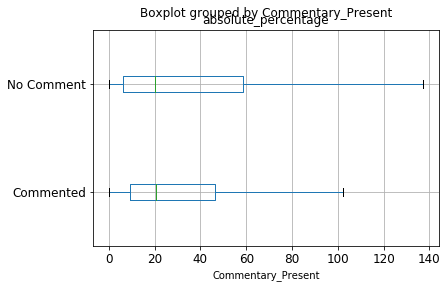

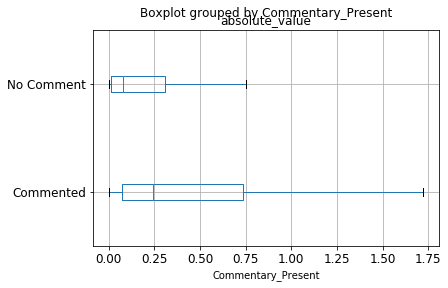

In [189]:
merged_2018_file.boxplot(column = ['absolute_percentage'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

merged_2018_file.boxplot(column = ['absolute_value'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

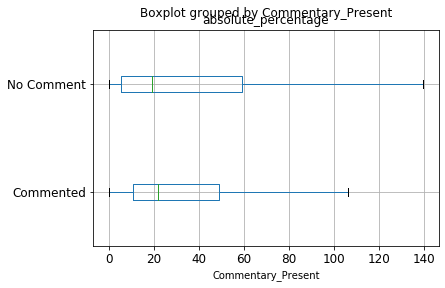

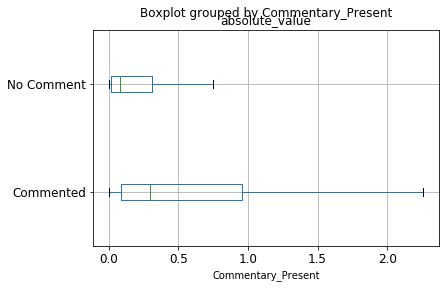

In [193]:
merged_2017_file.boxplot(column = ['absolute_percentage'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

merged_2017_file.boxplot(column = ['absolute_value'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

**Observation:** We can clearly see that in terms of median percentage there seems to be very small difference between when commentaries are written or not! On the other hand, in terms of pure numerical difference in Actual vs Plan, we see that median difference for commented values is \\$0.25M and the 25th percentile looks to be below \\$0.10M, compared against cases where no commentaries are present where the values are low. Further analysis below to see if there is any distinction in commentaries when split at \\$0.5M

Count of commented rows with movement <$0.5M: 2412 out of 20765 - 11.61569949434144 %


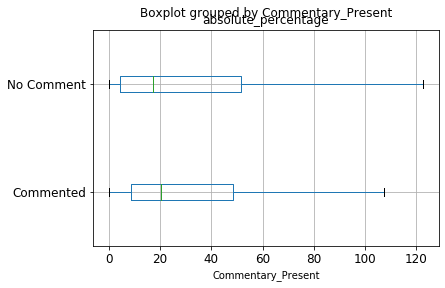

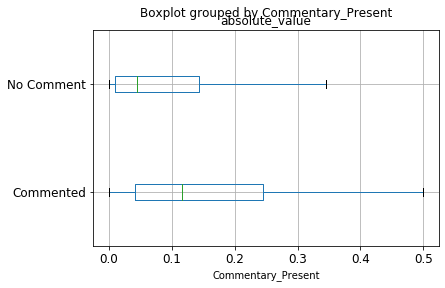

In [207]:
## Checking for commentaries written <$0.5MM

df_value_lessthan_point5M_2018 = merged_2018_file[merged_2018_file['absolute_value'] < 0.5]
print("Count of commented rows with movement <$0.5M:",df_value_lessthan_point5M_2018['Comment'].count(), "out of", len(df_value_lessthan_point5M_2018), '-',
      (df_value_lessthan_point5M_2018['Comment'].count()/ len(df_value_lessthan_point5M_2018)*100), '%')

df_value_lessthan_point5M_2018.boxplot(column = ['absolute_percentage'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

df_value_lessthan_point5M_2018.boxplot(column = ['absolute_value'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

Count of commented rows with movement >$0.5M: 1196 out of 5321 - 22.476978011651948 %


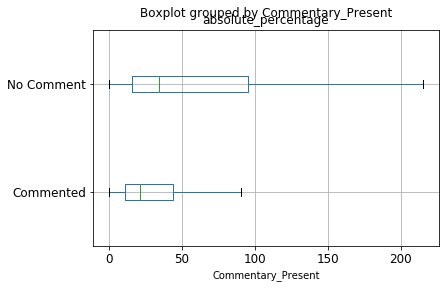

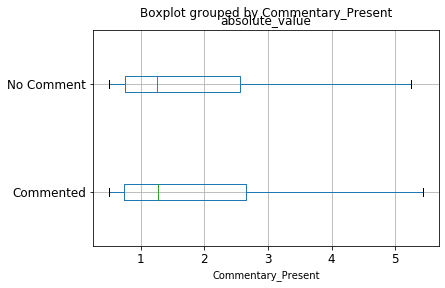

In [208]:
## Checking for commentaries written >=$0.5MM

df_value_greaterthan_point5M_2018 = merged_2018_file[merged_2018_file['absolute_value'] >= 0.5]
print("Count of commented rows with movement >$0.5M:",df_value_greaterthan_point5M_2018['Comment'].count(), "out of", len(df_value_greaterthan_point5M_2018), '-',
      (df_value_greaterthan_point5M_2018['Comment'].count()/ len(df_value_greaterthan_point5M_2018)*100), '%')

df_value_greaterthan_point5M_2018.boxplot(column = ['absolute_percentage'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

df_value_greaterthan_point5M_2018.boxplot(column = ['absolute_value'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

Count of commented rows with movement >15%: 2197 out of 15075 - 14.573797678275291 %


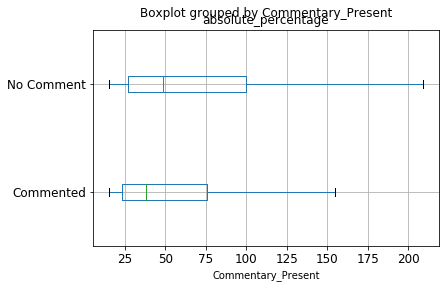

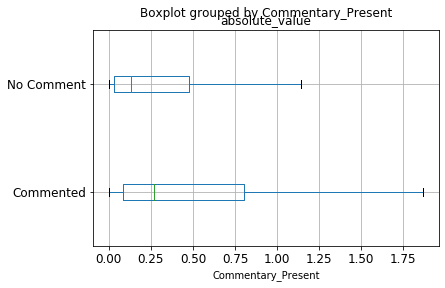

In [213]:
## Checking for commentaries written >15%

df_value_greaterthan_percent15_2018 = merged_2018_file[merged_2018_file['absolute_percentage'] >= 15]
print("Count of commented rows with movement >15%:",df_value_greaterthan_percent15_2018['Comment'].count(), "out of", len(df_value_greaterthan_percent15_2018), '-',
      (df_value_greaterthan_percent15_2018['Comment'].count()/ len(df_value_greaterthan_percent15_2018)*100), '%')

df_value_greaterthan_percent15_2018.boxplot(column = ['absolute_percentage'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

df_value_greaterthan_percent15_2018.boxplot(column = ['absolute_value'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

Count of commented rows with movement >$0.5M and 15%: 755 out of 3890 - 19.408740359897173 %


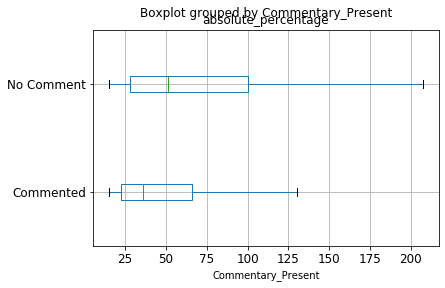

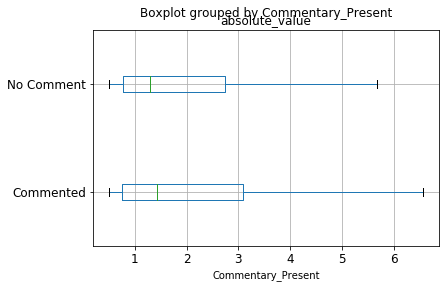

In [212]:
## Checking for commentaries written >=$0.5MM and >15%

df_value_greaterthan_point5M_2018_andpercent15 = merged_2018_file[(merged_2018_file['absolute_value'] >= 0.5) & (merged_2018_file['absolute_percentage'] >= 15)]
print("Count of commented rows with movement >$0.5M and 15%:",df_value_greaterthan_point5M_2018_andpercent15['Comment'].count(), "out of", len(df_value_greaterthan_point5M_2018_andpercent15), '-',
      (df_value_greaterthan_point5M_2018_andpercent15['Comment'].count()/ len(df_value_greaterthan_point5M_2018_andpercent15)*100), '%')

df_value_greaterthan_point5M_2018_andpercent15.boxplot(column = ['absolute_percentage'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

df_value_greaterthan_point5M_2018_andpercent15.boxplot(column = ['absolute_value'] , by =  'Commentary_Present', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False # Remove outliers beyond whiskers plot
                        )

Although the initial box-plot showed some promise in terms of value acting as a threshold, further analysis has not supported that:
* Out of ~3600 commentaries, ~66% of them actually have value change <\\$0.5M
* In terms of percentages though, 60% of commentaries have their corresponding percentage deviation >15%
* Filtering the data for <0.5M, percentage boxplot looks similar for comment vs. non-comment, but value shows a huge difference, generally being greater (11% of all candiates have commentaries) - does this mean that <0.5M,there is another value threshold because percentages looks so similar??
* Filtering the data for >0.5M, value boxplot looks similar, but percentage deviation has actually smaller values for comments compared to non-comments! (22% of all candiates have commentaries) **i.e. if the value of 0.5M has been reached, the analyst is not making a decision to write a commentary based on value or percentage! - >0.5M seems to be a false boundary**
* If we filter the data for >15% deviation from actuals, then it would seem that data showing greater value movements, but lower percentages have commentaries (This could be because big product categories could show huge value movements when compared to small categories but which translates to small percentage changes). So, at this threshold again, analyst seems to be making decision based on value
* Lastly, if we apply the filter of both \\$0.5M and 15% thresholds, only 20% of these data points have commentaries, so this 'and' condition is incorrect. Also, commentaries at this threshold constitute of only 21% of all commentaries written


**It could seem that a good proportion of commentaries are written keeping the percentage threshold in mind, BUT, one only needs to go back up the 1st boxplots, which shows that there is no difference in distribution of percentage values for comments vs. non-comments. 2 possible hypothesis come to mind, which feed on each other:**

1. We see that most of the commentaries are written at either <\\$0.5M or >15%. We could lower both of these thresholds to include all cases of commentaries but that would greatly increase the candidate cases! Also, lowering the difference value but increasing the percentage would not work because then we are reducing commentaries meeting the percentage threshold. **So, the thumb-rule may infact be a non-rule!!!!**
2. Comments are being written not just looking at the change in NTS values, but also other GL values and the analyst makes a human decision whether to write it or not

#### Box plots for commented data across diferent views

In [ ]:
df_commented = merged_2018_file[~merged_2018_file['Comment'].isna()]
df_commented.head()

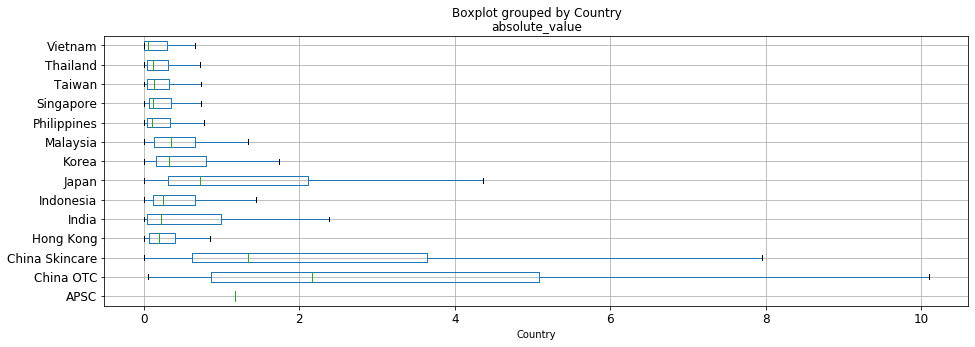

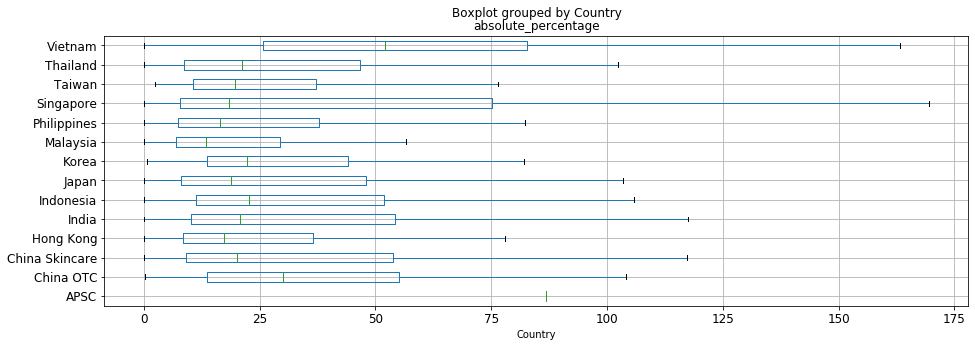

In [228]:
df_commented.boxplot(column = ['absolute_value'] , by =  'Country', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False, # Remove outliers beyond whiskers plot
                         figsize = (15,5)
                        )
df_commented.boxplot(column = ['absolute_percentage'] , by =  'Country', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False, # Remove outliers beyond whiskers plot
                         figsize = (15,5)
                        )

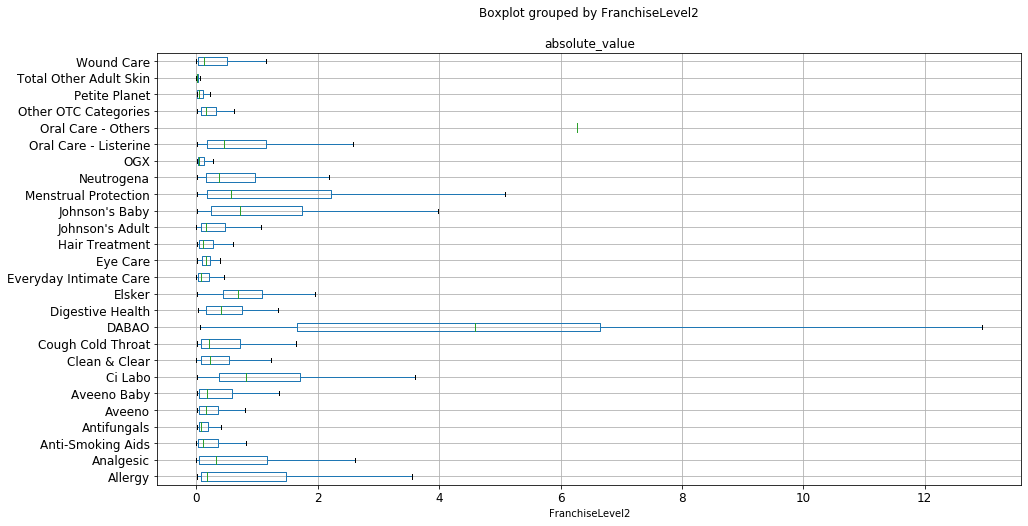

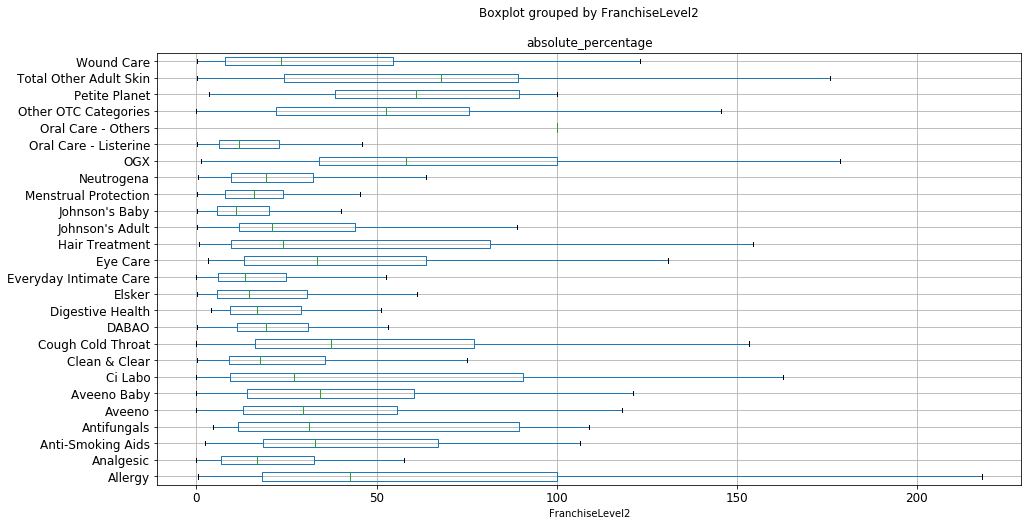

In [227]:
df_commented.boxplot(column = ['absolute_value'] , by =  'FranchiseLevel2', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False, # Remove outliers beyond whiskers plot
                         figsize = (15,8)
                        )
df_commented.boxplot(column = ['absolute_percentage'] , by =  'FranchiseLevel2', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False, # Remove outliers beyond whiskers plot
                         figsize = (15,8)
                        )

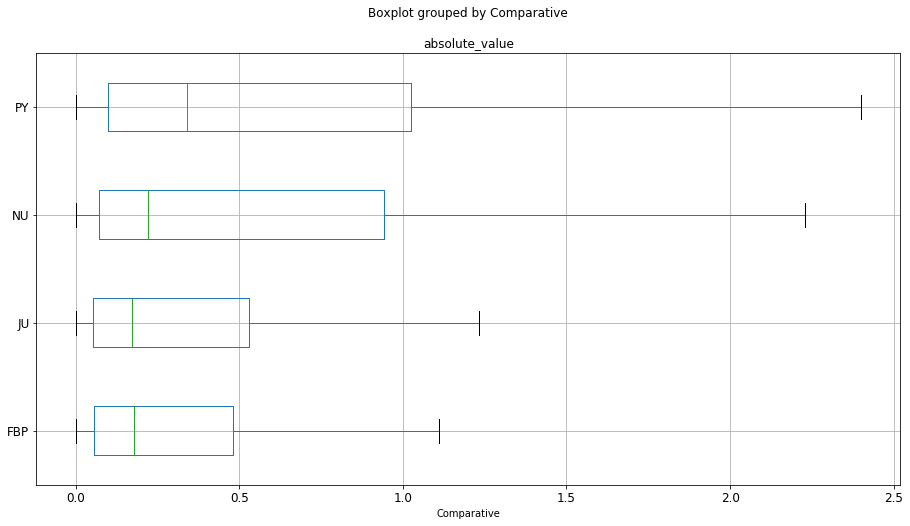

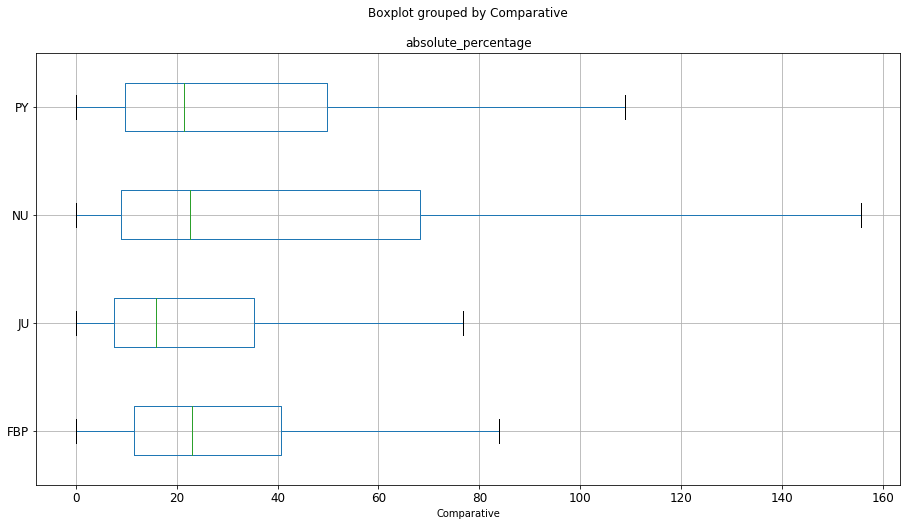

In [236]:
df_commented.boxplot(column = ['absolute_value'] , by =  'Comparative', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False, # Remove outliers beyond whiskers plot
                         figsize = (15,8)
                        )
df_commented.boxplot(column = ['absolute_percentage'] , by =  'Comparative', 
                         #figsize = (15,3), 
                         fontsize = 'large',
                         vert = False,
                        showfliers = False, # Remove outliers beyond whiskers plot
                         figsize = (15,8)
                        )

The above graphs further highlight the inconsistency of the application of thumb rule (if there is any).

### Trying to solve the rule problem using signal detection analogy

In [ ]:
# Input GL data - we are not trying to incorporate flxibility here; this is just a pilot concept for now!
GL_data = pd.read_excel(r'Consumer GL Data 2016-2018 v2.xlsx')
#commentaries_calculation_2018 = pd.read_csv("FranchiseLevel2_Commentary_calculation_2018.csv")
GL_data

In [17]:
# Filtering required data
Accounts_to_analyze = ['Brand Marketing Expenses', '655200 - Mkt & Cons Research EB', '650200 - Transportation', '605140 - Inventory Adjustments EB','605000 - COG&S Sold Trade EB']

def GL_wrangling_func(Year, GLdata, Accounts):
    GLdata = GLdata[(GLdata['Year'] == Year) | ((GLdata['Year'] == Year-1) &  (GLdata['Version'] == 'ACT'))]
    GLdata['Country'] = GLdata['Country'].str[9:]
    GLdata['Version'] = np.where( (GLdata['Version'] == 'ACT') & (GLdata['Year'] == Year -1), 'PY', GLdata['Version'])
    GLdata['Country'] = np.where(GLdata['Country'] == 'China Consumer',  'China Skincare', GLdata['Country'])
    GLdata['Country'] = np.where(GLdata['Country'] == 'China Personal Health',  'China Skin', GLdata['Country'])
    
    
    ## Filtering only for some accounts to keep things manageble
    GLdata = GLdata[GLdata['GL Account'].isin(Accounts)]
    
    GLdata_longformat = pd.wide_to_long(GLdata, i = ['Country','Version','Year','Product','GL Account'], 
                                              j = 'Month_key', stubnames = '')
    GLdata_longformat.reset_index(drop = False, inplace = True) 
    GLdata_longformat.set_axis([*GLdata_longformat.columns[:-1], 'Values'], axis=1, inplace=True)
    print("Shape of long data:", GLdata_longformat.shape)
    
    # Pivoting the table so all metrics become columns 
    Gldata_pivot = GLdata_longformat.pivot_table(index = ['Country','Version','Year','Product', 'Month_key'], columns = 'GL Account', values = 'Values')
    Gldata_pivot.reset_index(drop = False, inplace = True)
    Gldata_pivot.fillna(0)
    #Gldata_pivot.dropna(inplace = True)
    print("Shape of pivot data:", Gldata_pivot.shape)
    
    # YTD calculation
    Gldata_calculations_YTD = Gldata_pivot.sort_values(by = ['Country','Version','Year','Product','Month_key'], axis = 0, ascending = True).groupby(['Country','Version','Year','Product'])[Accounts].apply(lambda x : x.astype(float).cumsum())
    Gldata_calculations_YTD.reset_index(drop = False, inplace = True)
    print("Shape of YTD calculated data:", Gldata_calculations_YTD.shape)
    Gldata_calculations_YTD.drop(columns = 'index', inplace = True) #Dropping a remnant column
    Gldata_calculations_YTD.reset_index(drop = True, inplace = True)
    Gldata_calculations_YTD = Gldata_calculations_YTD.add_suffix('_YTD')
    
    # QTD Calculations
    Gldata_calculations_QTD = Gldata_pivot.copy()
    Gldata_calculations_QTD['Quarter_Indicator'] = ((Gldata_calculations_QTD['Month_key'] - 1)/3).astype(int) #Every quarter has the same number
    Gldata_calculations_QTD = Gldata_calculations_QTD.sort_values(by = ['Country','Version','Year','Product','Month_key'], axis = 0, ascending = True).groupby(['Country','Version','Year','Product', 'Quarter_Indicator'])[Accounts].apply(lambda x : x.astype(float).cumsum())
    Gldata_calculations_QTD.reset_index(drop = False, inplace = True)
    print("Shape of QTD calculated data:", Gldata_calculations_QTD.shape)
    Gldata_calculations_QTD.drop(columns = 'index', inplace = True) #Dropping a remnant column
    Gldata_calculations_QTD.reset_index(drop = True, inplace = True)
    Gldata_calculations_QTD = Gldata_calculations_QTD.add_suffix('_QTD')

    
    # Merging all dataframes
    Gldata_pivot = Gldata_pivot.sort_values(by = ['Country','Version','Year','Product','Month_key'], axis = 0, ascending = True).reset_index(drop = True)
    Gldata_pivot = pd.concat([Gldata_pivot,Gldata_calculations_YTD,Gldata_calculations_QTD], axis = 1)
    return Gldata_pivot
    
    # Adding quarter indicator for QTD calculation

Required_GL_data = GL_wrangling_func(2018, GL_data, Accounts = Accounts_to_analyze)    

C:\Users\uchaturv\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uchaturv\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\uchaturv\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

Shape of long data: (173616, 7)
Shape of pivot data: (48756, 10)
Shape of YTD calculated data: (48756, 6)
Shape of QTD calculated data: (48756, 6)


In [ ]:
## Because GL data does not have hierarchy, we have to read in consumer sales data to map that
sales_df_2018 = pd.read_csv(r'Consumer Sales Data 2018.csv')
sales_df_2018 = sales_df_2018[['FranchiseLevel1','FranchiseLevel2','SKU']]

# Accounts for analysis
Accounts_to_analyze
Accounts_YTD = [account + '_YTD' for account in Accounts_to_analyze]
Accounts_QTD = [account + '_QTD' for account in Accounts_to_analyze]
Accounts_all = Accounts_to_analyze + Accounts_YTD + Accounts_QTD
#Accounts_all.extend(Accounts_to_analyze).extend(Accounts_QTD).extend(Accounts_YTD)
print(Accounts_all)

#Joining sales hierarchy levels to GL data
Required_GL_data_merged = Required_GL_data.merge(sales_df_2018, how = 'left', left_on = 'Product', right_on = 'SKU')

# Rolling up data to FranchiseLevel2 as the analysis is being done on that level
Required_GL_data_rolledup = Required_GL_data_merged.groupby(['Country','Version','Month_key', 'FranchiseLevel1','FranchiseLevel2'])[Accounts_all].sum().reset_index(drop = False)


Required_GL_data_rolledup

In [506]:
## Combining the above created file with merged_2018 dataframe created in the boxplot section above

Commentary_calculation_data = merged_2018_file[['Period_Type','Comparitive','Month_key','Month_x','Country', 'FranchiseLevel1','FranchiseLevel2','h_1_value', 'h_1_percentage','Commentary_Present']]

# Dictionary to store values acorss all accounts
GLaccount_dict_values = {'Brand Marketing Expenses' : [],
                         '655200 - Mkt & Cons Research EB': [],
                         '650200 - Transportation': [],
                         '605140 - Inventory Adjustments EB': [],
                         '605000 - COG&S Sold Trade EB': []}
GLaccount_dict_percent = {'Brand Marketing Expenses' : [],
                         '655200 - Mkt & Cons Research EB': [],
                         '650200 - Transportation': [],
                         '605140 - Inventory Adjustments EB': [],
                         '605000 - COG&S Sold Trade EB': []}

for index,row in Commentary_calculation_data.iterrows():
    #print(row)
    Comparative = row.Comparitive
    month_key = row.Month_key
    country = row.Country
    hierarchy_level = row.FranchiseLevel2
    
    condition = (Required_GL_data_rolledup.Month_key == month_key) & \
                (Required_GL_data_rolledup.FranchiseLevel2 == hierarchy_level) & \
                (Required_GL_data_rolledup.Country == country)
    
    Period_type = row.Period_Type
    
    Filtered_data = Required_GL_data_rolledup[condition]
    
    if len(Filtered_data) == 0:
        value = 'NA'
        percent = 'NA'
        GLaccount_dict_values[account].append(value) 
        GLaccount_dict_percent[account].append(percent) 
        
    else:
        if Period_type == 'YTD':
            for account in Accounts_to_analyze:
                column = account + '_YTD'
                actual = Filtered_data[Filtered_data['Version'] == 'ACT'][column].values
                comparative = Filtered_data[Filtered_data['Version'] == Comparative][column].values

                if (actual.size == 0) | (comparative.size == 0):
                    value = 'NA'
                    percent = 'NA'
                else:
                    actual = actual[0]
                    comparative = comparative[0]

                    value = [actual-comparative]
                    if comparative == 0:
                        percent = value
                    else:
                        percent = (value/abs(comparative)) * 100
                
                
                GLaccount_dict_values[account].append(value) 
                GLaccount_dict_percent[account].append(percent) 
                #print(index, account, value, percent)
        
        
        elif Period_type == 'QTD':
            for account in Accounts_to_analyze:
                column = account + '_QTD'
                actual = Filtered_data[Filtered_data['Version'] == 'ACT'][column].values
                comparative = Filtered_data[Filtered_data['Version'] == Comparative][column].values

                if (actual.size == 0) | (comparative.size == 0):
                    value = 'NA'
                    percent = 'NA'
                else:
                    actual = actual[0]
                    comparative = comparative[0]

                    value = [actual-comparative]
                    if comparative == 0:
                        percent = value
                    else:
                        percent = (value/abs(comparative)) * 100
                
                
                GLaccount_dict_values[account].append(value) 
                GLaccount_dict_percent[account].append(percent) 
                #print(index, account, value, percent)
        
        
        else:
            for account in Accounts_to_analyze:
                column = account
                actual = Filtered_data[Filtered_data['Version'] == 'ACT'][column].values
                comparative = Filtered_data[Filtered_data['Version'] == Comparative][column].values

                if (actual.size == 0) | (comparative.size == 0):
                    value = 'NA'
                    percent = 'NA'
                else:
                    actual = actual[0]
                    comparative = comparative[0]

                    value = [actual-comparative]
                    if comparative == 0:
                        percent = value
                    else:
                        percent = (value/abs(comparative)) * 100
                
                
                GLaccount_dict_values[account].append(value) 
                GLaccount_dict_percent[account].append(percent)
                #print(index, account, value, percent)
    
    if index % 1000 == 0:
        print(index)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


In [552]:
GL_value_df = pd.DataFrame(GLaccount_dict_values)
GL_percent_df = pd.DataFrame(GLaccount_dict_percent)

GL_value_df = GL_value_df.add_suffix('_value')
GL_percent_df = GL_percent_df.add_suffix('_perc')

# Remove list from each element
GL_value_df = GL_value_df.applymap(lambda x: x[0])
GL_percent_df = GL_percent_df.applymap(lambda x: x[0])

In [553]:
Final_signalanalysis_dataset = pd.concat([Commentary_calculation_data,GL_value_df, GL_percent_df],axis = 1)

In [558]:
Final_signalanalysis_dataset.to_csv("Signalanalysis_df_FranchiseLevel2.csv", index = False)
GL_value_df.to_csv("Signalanalysis_df_FranchiseLevel2_Onlyvalue.csv", index = False)
GL_percent_df.to_csv("Signalanalysis_df_FranchiseLevel2_Onlypercent.csv", index = False)

#### Actual Signal Analysis

In [19]:
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from sklearn.model_selection import train_test_split

In [310]:
GL_value_df = pd.read_csv("Signalanalysis_df_FranchiseLevel2_Onlyvalue.csv")
GL_percent_df = pd.read_csv("Signalanalysis_df_FranchiseLevel2_Onlypercent.csv")
GL_all = pd.read_csv("Signalanalysis_df_FranchiseLevel2.csv")

In [ ]:
GL_all.replace('N', 0, inplace = True) #Because NA was replaced with N in the apply function above!
GL_all

In [312]:
# Converting all value to absolute - all calculations will be done on them
#GL_all = GL_all.iloc[:,7:].apply(lambda x: abs(x))

In [313]:
# Capping outrageously huge percentage numbers
#print("Shape of data:", GL_all.shape)

for column in GL_all.filter(regex = 'perc'):
    GL_all[column] = np.where(GL_all[column].astype('float64') > 500, 500, GL_all[column].astype('float64'))
    GL_all[column] = np.where(GL_all[column].astype('float64') < -500, -500, GL_all[column].astype('float64'))
    
'''GL_all = GL_all[abs(GL_all['h_1_percentage']) <= 1000] #<50 times increase in NTS compared to comparision value 
GL_all = GL_all[abs(GL_all['Brand Marketing Expenses_perc'].astype('float64')) <= 1000] #<50 times increase in NTS compared to comparision value 
GL_all = GL_all[abs(GL_all['655200 - Mkt & Cons Research EB_perc'].astype('float64'))  <= 1000] 
GL_all = GL_all[abs(GL_all['650200 - Transportation_perc'].astype('float64'))  <= 1000] 
GL_all = GL_all[abs(GL_all['605140 - Inventory Adjustments EB_perc'].astype('float64'))  <= 1000] 
GL_all = GL_all[abs(GL_all['605000 - COG&S Sold Trade EB_perc'].astype('float64'))  <= 1000] 
#print("Shape of data:", GL_all.shape)'''

'GL_all = GL_all[abs(GL_all[\'h_1_percentage\']) <= 1000] #<50 times increase in NTS compared to comparision value \nGL_all = GL_all[abs(GL_all[\'Brand Marketing Expenses_perc\'].astype(\'float64\')) <= 1000] #<50 times increase in NTS compared to comparision value \nGL_all = GL_all[abs(GL_all[\'655200 - Mkt & Cons Research EB_perc\'].astype(\'float64\'))  <= 1000] \nGL_all = GL_all[abs(GL_all[\'650200 - Transportation_perc\'].astype(\'float64\'))  <= 1000] \nGL_all = GL_all[abs(GL_all[\'605140 - Inventory Adjustments EB_perc\'].astype(\'float64\'))  <= 1000] \nGL_all = GL_all[abs(GL_all[\'605000 - COG&S Sold Trade EB_perc\'].astype(\'float64\'))  <= 1000] \n#print("Shape of data:", GL_all.shape)'

In [314]:
# Mahanobolis distance - calculated where commentary is NOT present

#Calculate the covariance matrix:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")
 
# Calculate the Mahalanobis distance:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

#Detecting outliers:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

# Calculate threshold value for classifying datapoint as anomaly: 3 Standard deviation
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

# Check if matrix is positive definite:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [317]:
# Splitting train & test
X_train, X_test, y_train, y_test = train_test_split(GL_all.drop(['Commentary_Present', 'Period_Type','Comparitive',
                                                                 'Month_key', 'Month_x', 'Country',
                                                                 'FranchiseLevel1','FranchiseLevel2'], axis = 1), GL_all['Commentary_Present'], test_size=0.2, random_state=42)

# Extracting only data points where no comment has been given which will go into Mahanobolis distance calculation
no_comment_index = y_train[y_train == 'No Comment'].index

X_train_nocomment = X_train[X_train.index.isin(no_comment_index)]
X_train_comment = X_train[~X_train.index.isin(no_comment_index)]

In [318]:
scaler = preprocessing.MinMaxScaler()

X_train_nocomment = pd.DataFrame(scaler.fit_transform(X_train_nocomment), 
                              columns=X_train_nocomment.columns, 
                              index=X_train_nocomment.index)
# Random shuffle training data
#X_train.sample(frac=1)
X_train_comment = pd.DataFrame(scaler.transform(X_train_comment), 
                             columns=X_train_comment.columns, 
                             index=X_train_comment.index)

X_test = pd.DataFrame(scaler.transform(X_test), 
                             columns=X_test.columns, 
                             index=X_test.index)

In [319]:
## PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=6, svd_solver= 'full')
X_train_nocomment_PCA = pca.fit_transform(X_train_nocomment)
X_train_nocomment_PCA = pd.DataFrame(X_train_nocomment_PCA)
X_train_nocomment_PCA.index = X_train_nocomment.index

X_train_comment_PCA = pca.transform(X_train_comment)
X_train_comment_PCA = pd.DataFrame(X_train_comment_PCA)
X_train_comment_PCA.index = X_train_comment.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [343]:
pca.explained_variance_ratio_

array([0.39436567, 0.256873  , 0.11800405, 0.09112982, 0.08006217,
       0.04306128])

In [320]:
data_train_nocomment = np.array(X_train_nocomment_PCA.values)
data_train_comment = np.array(X_train_comment_PCA.values)
data_test = np.array(X_test_PCA.values)

In [321]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train_nocomment)
mean_distr = data_train_nocomment.mean(axis=0)

dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=True)
dist_train_nocomment = MahalanobisDist(inv_cov_matrix, mean_distr, data_train_nocomment, verbose=True)
dist_train_comment = MahalanobisDist(inv_cov_matrix, mean_distr, data_train_comment, verbose=True)
# threshold defined on no-comment data
threshold = MD_threshold(dist_train_nocomment, extreme = True)

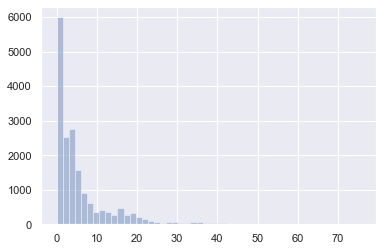

In [322]:
# The mahanobolis distance should ideally floow the chi-square distribution

plt.figure()
sns.distplot(np.square(dist_train_nocomment),
             bins = 50, 
             kde= False);
#plt.xlim([0.0,15])

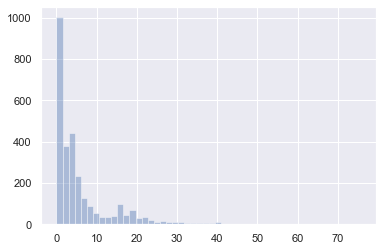

In [323]:
plt.figure()
sns.distplot(np.square(dist_train_comment),
             bins = 50, 
             kde= False);

Text(0.5, 0, 'Mahalanobis dist')

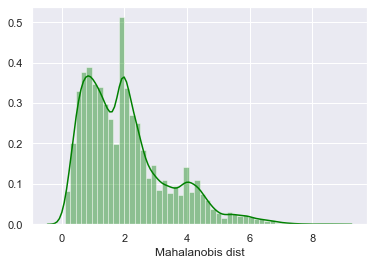

In [329]:
plt.figure()
sns.distplot(dist_train_nocomment,
             bins = 50, 
             kde= True, 
            color = 'green');
#plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

Text(0.5, 0, 'Mahalanobis dist')

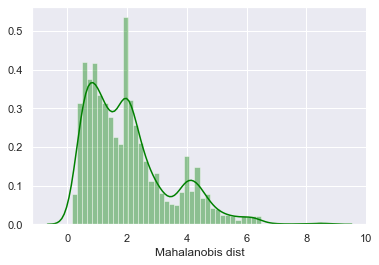

In [330]:
plt.figure()
sns.distplot(dist_train_comment,
             bins = 50, 
             kde= True, 
            color = 'green');
#plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

Text(0.5, 0, 'Mahalanobis dist')

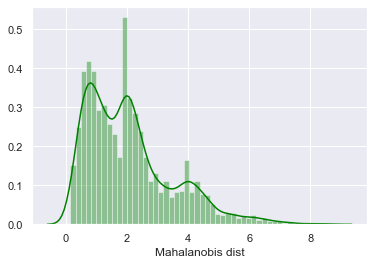

In [331]:
plt.figure()
sns.distplot(dist_test,
             bins = 50, 
             kde= True, 
            color = 'green');
#plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

#### Testing

In [337]:
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly = anomaly.join(y_test)
anomaly.head()

Mob dist    Thresh  Anomaly Commentary_Present
12477  0.290604  6.130466    False         No Comment
11743  1.113012  6.130466    False         No Comment
12829  4.403523  6.130466    False         No Comment
13064  3.226412  6.130466    False         No Comment
14442  3.295388  6.130466    False          Commented

Text(0.5, 0, 'Mahalanobis dist')

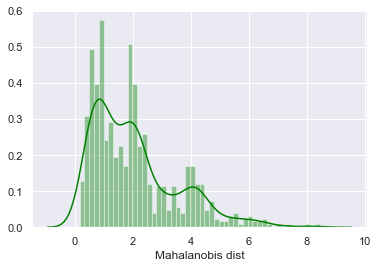

In [340]:
plt.figure()
sns.distplot(anomaly[anomaly['Commentary_Present'] == 'Commented']['Mob dist'],
             bins = 50, 
             kde= True, 
            color = 'green');
#plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')